In [5]:
import pandas as pd
from IPython.display import clear_output
from sklearn.metrics import recall_score, precision_score
!pip install catboost
!pip install shap
!pip install optuna
from catboost import CatBoostClassifier, Pool
import shap
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
import joblib
clear_output()

In [6]:
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',100)

In [7]:
df = pd.read_excel('../../База данных для конкурса.xls', sheet_name=None)

In [8]:
df.keys()

dict_keys(['Паспорт', 'Совершен1', 'Совершен2', 'Обслед', 'Семья', 'Дом хоз', 'Оценка терр', 'Физич акт', 'IPAQ', 'Питание', 'EPOCH2', 'Питание2'])

### Дом хоз

In [9]:
target = 'Артериальная гипертензия'
list_name = ['Дом хоз']

In [10]:
def create_model(df, target, list_name):
    for i, j in enumerate(list(set([list(df.keys())[1]] + list(list_name)))):
        if i ==0  and list_name[0] == 'Совершен1':
            df_all = df[j][['ID']]
        if i==0 and list_name[0] != 'Совершен1':
            df_all = df[j][['ID', 'Артериальная гипертензия',  'ОНМК',  'Стенокардия, ИБС, инфаркт миокарда',
                                'Сердечная недостаточность', 'Прочие заболевания сердца']]
        else:
            df_all = df_all.merge(df[j], on=['ID'], how='left')

    # Работа с конкретными колонками
    dropcols = ['Дата рождения', 'Национальность',
    'Даность ОНМК',
    'Длительность артериальной гипертензии',
'Длительность стенокардии, ИБС, инфаркта миокарда',
'Длительность сердечной недостаточности',
'Длительность прочих заболеваний сердца'
    ]
    df_all.drop(dropcols, axis=1, inplace=True, errors='ignore')
    if 'Время засыпания' in df_all.columns:
        df_all['Время засыпания'] = df_all['Время засыпания'].apply(lambda x: str(x).split(':')[0]).astype(int)
        df_all['Время пробуждения'] = df_all['Время пробуждения'].apply(lambda x: str(x).split(':')[0]).astype(int)
    cols = []
    for i in df_all.columns:
      if i not in ['ID', 'Артериальная гипертензия',  'ОНМК',  'Стенокардия, ИБС, инфаркт миокарда',
                                'Сердечная недостаточность', 'Прочие заболевания сердца']:
        cols.append(i)
    return df_all, cols

In [11]:
def create_pool(df_all, cols, target):
    # Категориальные фичи
    cats = []
    for i in cols:
        if df_all[i].dtype == 'O':
            cats.append(i)
    df_all[cats] = df_all[cats].fillna("Undefined")
    df_all['target'] = df_all[target]
    X_train, X_val, y_train, y_val = train_test_split(df_all[cols],
                                                      df_all.target,
                                                     test_size=0.3, stratify=df_all.target, random_state=123)
    train_pool = Pool(X_train, y_train, cat_features=cats)
    val_pool = Pool(X_val, y_val, cat_features=cats)
    return train_pool, val_pool, X_val

In [12]:
def objective(trial): 
    param = {                 
            'depth' : trial.suggest_int('max_depth',1,5),
            'n_estimators':  trial.suggest_int("n_estimators", 100, 1000),
            'l2_leaf_reg': trial.suggest_uniform("reg_lambda", 0, 100),
            'learning_rate' : trial.suggest_loguniform('learning_rate',0.01,0.2),
            'border_count': trial.suggest_int("border_count", 1, 255),
            'random_strength' : trial.suggest_loguniform('random_strength', 1e-9, 10),
            'bagging_temperature': trial.suggest_uniform("bagging_temperature", 0, 1),
        #'task_type': 'GPU',
        "loss_function":'Logloss', 
        "random_state":123, 
        "verbose": False
    }
    
    cb = CatBoostClassifier(**param, eval_metric='AUC')
    cb.fit(train_pool, eval_set=val_pool, early_stopping_rounds=150, verbose=0)
    
    train_auc = roc_auc_score(train_pool.get_label(), cb.predict_proba(train_pool)[:,1])
    test_auc = roc_auc_score(val_pool.get_label(), cb.predict_proba(val_pool)[:,1])
    print(f"TRAIN AUC = {train_auc:.6}")
    print(f"Validate AUC = {test_auc:.6}")
    print(cb.get_params())
    return test_auc

In [13]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)

In [14]:
def hyperparameters(train_pool, val_pool, X_val, optuna_use=False, params={}):
  if optuna_use:
    print('Подбор параметров')

    study_cb = optuna.create_study(direction='maximize')
    study_cb.optimize(objective, n_trials=25)
    cb = CatBoostClassifier(**study_cb.best_params, eval_metric='AUC')
  elif params != {}:
    cb = CatBoostClassifier(**params, eval_metric='AUC')

  else:
    cb = CatBoostClassifier(random_state=123, eval_metric='AUC', verbose=0)

  cb.fit(train_pool, eval_set=val_pool, early_stopping_rounds=150, verbose=0)
  print(f"Validate AUC ({len(X_val.columns)} features) = {roc_auc_score(val_pool.get_label(), cb.predict_proba(val_pool)[:,1]):.6}")
  imps = cb.get_feature_importance(val_pool, type='ShapValues')
  cb_imps2 = pd.DataFrame({'cols':train_pool.get_feature_names(), 'imps': np.mean(np.abs(imps),axis=0)[:-1],
                          'imps_not_norm': np.mean((imps),axis=0)[:-1]}).sort_values(by=['imps'],\
                                                                                                  ascending=False)
  shap_values = cb.get_feature_importance(val_pool, type='ShapValues')[:,:-1]
  shap.summary_plot(shap_values, X_val, max_display=15)
  return cb_imps2, cb

Validate AUC (54 features) = 0.625531


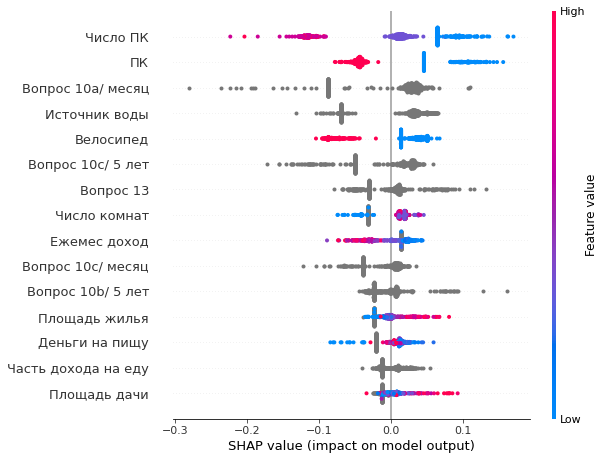

In [15]:
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [16]:
cb_imps2

,cols,imps,imps_not_norm
13,Число ПК,0.062117,0.011258
12,ПК,0.055725,0.000734
32,Вопрос 10a/ месяц,0.049364,-0.006083
4,Источник воды,0.046501,0.002666
10,Велосипед,0.043679,0.000569
37,Вопрос 10c/ 5 лет,0.039182,-0.009137
49,Вопрос 13,0.025131,-0.003842
52,Число комнат,0.022732,-0.000849
25,Ежемес доход,0.022595,-0.000809
36,Вопрос 10c/ месяц,0.019980,-0.009954


Validate AUC (8 features) = 0.631019


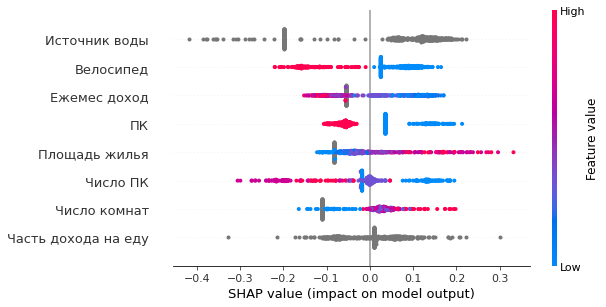

In [17]:
new_feats = ['Число ПК', 'Площадь жилья', 'Велосипед', 'Ежемес доход',
 'Источник воды', 'Часть дохода на еду', 'Число комнат', 'ПК'	]
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [18]:
cb_imps2

,cols,imps,imps_not_norm
4,Источник воды,0.145993,0.020939
2,Велосипед,0.086502,0.009812
3,Ежемес доход,0.080024,-0.003961
7,ПК,0.069215,-0.005518
1,Площадь жилья,0.069181,-0.014891
0,Число ПК,0.065869,-0.018551
6,Число комнат,0.058837,-0.009623
5,Часть дохода на еду,0.054374,0.004729


In [19]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

In [21]:
df_all.to_csv('df_all.csv')

Таргет 2

Validate AUC (54 features) = 0.71788


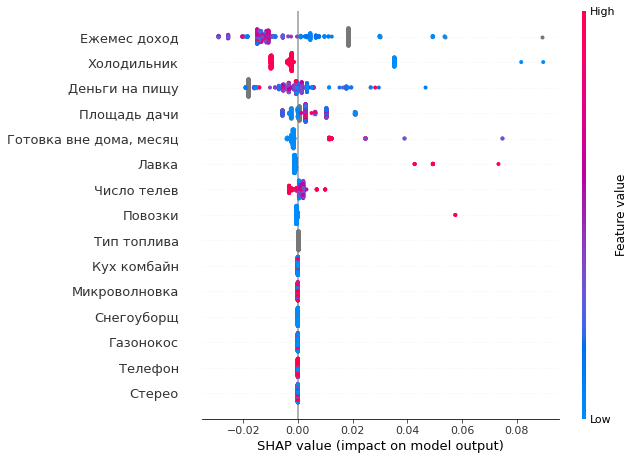

In [ ]:
target = 'ОНМК'
list_name = ['Дом хоз']
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [ ]:
cb_imps2

,cols,imps,imps_not_norm
25,Ежемес доход,0.014599,-0.002636
16,Холодильник,0.010969,0.002972
26,Деньги на пищу,0.007249,-0.003833
28,Площадь дачи,0.003962,0.002264
31,"Готовка вне дома, месяц",0.003560,0.000017
45,Лавка,0.002282,0.000203
18,Число телев,0.001519,0.000546
11,Повозки,0.000667,-0.000187
32,Вопрос 10a/ месяц,0.000000,0.000000
33,Вопрос 10a/ 5 лет,0.000000,0.000000


In [ ]:
new_feats = ['Ежемес доход', 'Холодильник', 'Деньги на пищу', 'Площадь дачи', 'Готовка вне дома, месяц',
 'Лавка', 'Число телев']

Validate AUC (7 features) = 0.728152


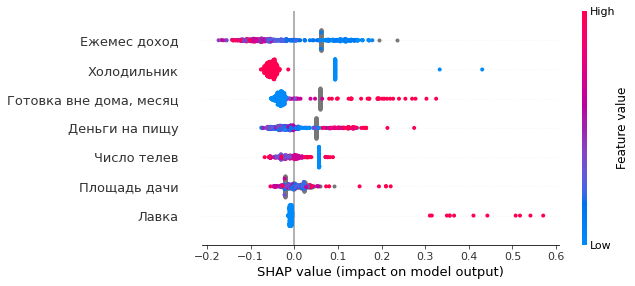

In [ ]:
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [ ]:
cb_imps2

,cols,imps,imps_not_norm
0,Ежемес доход,0.078677,-0.002641
1,Холодильник,0.061581,-0.023273
4,"Готовка вне дома, месяц",0.046313,-0.000677
2,Деньги на пищу,0.044058,0.013041
6,Число телев,0.025810,0.002732
3,Площадь дачи,0.020229,0.000436
5,Лавка,0.017975,0.003036


In [ ]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 3

[I 2020-11-28 10:11:35,340] A new study created in memory with name: no-name-43de962f-b274-4f51-8658-ef207cf1bed8


Подбор параметров


[I 2020-11-28 10:11:43,109] Trial 0 finished with value: 0.555235718024075 and parameters: {'max_depth': 1, 'n_estimators': 547, 'reg_lambda': 48.00557815609263, 'learning_rate': 0.027772656408346672, 'border_count': 49, 'random_strength': 1.0986055264395942e-07, 'bagging_temperature': 0.5581872275000522}. Best is trial 0 with value: 0.555235718024075.


TRAIN AUC = 0.644695
Validate AUC = 0.555236
{'random_state': 123, 'n_estimators': 547, 'task_type': 'GPU', 'bagging_temperature': 0.5581872275000522, 'eval_metric': 'AUC', 'random_strength': 1.0986055264395942e-07, 'verbose': False, 'border_count': 49, 'loss_function': 'Logloss', 'l2_leaf_reg': 48.00557815609263, 'depth': 1, 'learning_rate': 0.027772656408346672}


[I 2020-11-28 10:11:49,259] Trial 1 finished with value: 0.5708965739361488 and parameters: {'max_depth': 2, 'n_estimators': 557, 'reg_lambda': 15.834681619816582, 'learning_rate': 0.04972973060347934, 'border_count': 3, 'random_strength': 3.080007412468612e-08, 'bagging_temperature': 0.47828574621193076}. Best is trial 1 with value: 0.5708965739361488.


TRAIN AUC = 0.616693
Validate AUC = 0.570897
{'random_state': 123, 'n_estimators': 557, 'task_type': 'GPU', 'bagging_temperature': 0.47828574621193076, 'eval_metric': 'AUC', 'random_strength': 3.080007412468612e-08, 'verbose': False, 'border_count': 3, 'loss_function': 'Logloss', 'l2_leaf_reg': 15.834681619816582, 'depth': 2, 'learning_rate': 0.04972973060347934}


[I 2020-11-28 10:11:53,484] Trial 2 finished with value: 0.5739562784331093 and parameters: {'max_depth': 1, 'n_estimators': 970, 'reg_lambda': 98.4528067960312, 'learning_rate': 0.03263088340848505, 'border_count': 16, 'random_strength': 4.964790425088675, 'bagging_temperature': 0.32353272843483316}. Best is trial 2 with value: 0.5739562784331093.


TRAIN AUC = 0.516031
Validate AUC = 0.573956
{'random_state': 123, 'n_estimators': 970, 'task_type': 'GPU', 'bagging_temperature': 0.32353272843483316, 'eval_metric': 'AUC', 'random_strength': 4.964790425088675, 'verbose': False, 'border_count': 16, 'loss_function': 'Logloss', 'l2_leaf_reg': 98.4528067960312, 'depth': 1, 'learning_rate': 0.03263088340848505}


[I 2020-11-28 10:11:58,900] Trial 3 finished with value: 0.5262289142074963 and parameters: {'max_depth': 1, 'n_estimators': 826, 'reg_lambda': 62.13753542024412, 'learning_rate': 0.035715713784546715, 'border_count': 12, 'random_strength': 0.0005607754070040242, 'bagging_temperature': 0.9094594771865785}. Best is trial 2 with value: 0.5739562784331093.


TRAIN AUC = 0.591493
Validate AUC = 0.526229
{'random_state': 123, 'n_estimators': 826, 'task_type': 'GPU', 'bagging_temperature': 0.9094594771865785, 'eval_metric': 'AUC', 'random_strength': 0.0005607754070040242, 'verbose': False, 'border_count': 12, 'loss_function': 'Logloss', 'l2_leaf_reg': 62.13753542024412, 'depth': 1, 'learning_rate': 0.035715713784546715}


[I 2020-11-28 10:12:01,412] Trial 4 finished with value: 0.57228551874069 and parameters: {'max_depth': 1, 'n_estimators': 153, 'reg_lambda': 84.98427027420645, 'learning_rate': 0.06543924092277437, 'border_count': 208, 'random_strength': 5.965089974577758e-07, 'bagging_temperature': 0.07059224936883501}. Best is trial 2 with value: 0.5739562784331093.


TRAIN AUC = 0.635052
Validate AUC = 0.572286
{'random_state': 123, 'n_estimators': 153, 'task_type': 'GPU', 'bagging_temperature': 0.07059224936883501, 'eval_metric': 'AUC', 'random_strength': 5.965089974577758e-07, 'verbose': False, 'border_count': 208, 'loss_function': 'Logloss', 'l2_leaf_reg': 84.98427027420645, 'depth': 1, 'learning_rate': 0.06543924092277437}


[I 2020-11-28 10:12:10,503] Trial 5 finished with value: 0.5854100406618623 and parameters: {'max_depth': 4, 'n_estimators': 965, 'reg_lambda': 59.84015369454656, 'learning_rate': 0.093179697798458, 'border_count': 75, 'random_strength': 0.00016774111368325991, 'bagging_temperature': 0.6133056596040376}. Best is trial 5 with value: 0.5854100406618623.


TRAIN AUC = 0.636446
Validate AUC = 0.58541
{'random_state': 123, 'n_estimators': 965, 'task_type': 'GPU', 'bagging_temperature': 0.6133056596040376, 'eval_metric': 'AUC', 'random_strength': 0.00016774111368325991, 'verbose': False, 'border_count': 75, 'loss_function': 'Logloss', 'l2_leaf_reg': 59.84015369454656, 'depth': 4, 'learning_rate': 0.093179697798458}


[I 2020-11-28 10:12:15,858] Trial 6 finished with value: 0.5672128507588872 and parameters: {'max_depth': 4, 'n_estimators': 353, 'reg_lambda': 40.541586338312406, 'learning_rate': 0.1589155459557006, 'border_count': 21, 'random_strength': 0.8859472309987854, 'bagging_temperature': 0.7979829529820179}. Best is trial 5 with value: 0.5854100406618623.


TRAIN AUC = 0.607476
Validate AUC = 0.567213
{'random_state': 123, 'n_estimators': 353, 'task_type': 'GPU', 'bagging_temperature': 0.7979829529820179, 'eval_metric': 'AUC', 'random_strength': 0.8859472309987854, 'verbose': False, 'border_count': 21, 'loss_function': 'Logloss', 'l2_leaf_reg': 40.541586338312406, 'depth': 4, 'learning_rate': 0.1589155459557006}


[I 2020-11-28 10:12:17,674] Trial 7 finished with value: 0.5480896976528846 and parameters: {'max_depth': 1, 'n_estimators': 101, 'reg_lambda': 94.3438066505699, 'learning_rate': 0.09270444057790332, 'border_count': 34, 'random_strength': 0.022043597887173774, 'bagging_temperature': 0.2927137194091496}. Best is trial 5 with value: 0.5854100406618623.


TRAIN AUC = 0.649028
Validate AUC = 0.54809
{'random_state': 123, 'n_estimators': 101, 'task_type': 'GPU', 'bagging_temperature': 0.2927137194091496, 'eval_metric': 'AUC', 'random_strength': 0.022043597887173774, 'verbose': False, 'border_count': 34, 'loss_function': 'Logloss', 'l2_leaf_reg': 94.3438066505699, 'depth': 1, 'learning_rate': 0.09270444057790332}


[I 2020-11-28 10:12:31,402] Trial 8 finished with value: 0.5914086718466927 and parameters: {'max_depth': 4, 'n_estimators': 493, 'reg_lambda': 95.88723448748118, 'learning_rate': 0.027651363963735368, 'border_count': 254, 'random_strength': 0.24794494261752043, 'bagging_temperature': 0.5189546154375595}. Best is trial 8 with value: 0.5914086718466927.


TRAIN AUC = 0.634161
Validate AUC = 0.591409
{'random_state': 123, 'n_estimators': 493, 'task_type': 'GPU', 'bagging_temperature': 0.5189546154375595, 'eval_metric': 'AUC', 'random_strength': 0.24794494261752043, 'verbose': False, 'border_count': 254, 'loss_function': 'Logloss', 'l2_leaf_reg': 95.88723448748118, 'depth': 4, 'learning_rate': 0.027651363963735368}


[I 2020-11-28 10:12:42,366] Trial 9 finished with value: 0.5588791819316399 and parameters: {'max_depth': 5, 'n_estimators': 634, 'reg_lambda': 20.708657130137954, 'learning_rate': 0.02081546784742541, 'border_count': 136, 'random_strength': 5.547316345172951e-08, 'bagging_temperature': 0.01889846616006552}. Best is trial 8 with value: 0.5914086718466927.


TRAIN AUC = 0.59414
Validate AUC = 0.558879
{'random_state': 123, 'n_estimators': 634, 'task_type': 'GPU', 'bagging_temperature': 0.01889846616006552, 'eval_metric': 'AUC', 'random_strength': 5.547316345172951e-08, 'verbose': False, 'border_count': 136, 'loss_function': 'Logloss', 'l2_leaf_reg': 20.708657130137954, 'depth': 5, 'learning_rate': 0.02081546784742541}


[I 2020-11-28 10:12:48,683] Trial 10 finished with value: 0.5360723056483755 and parameters: {'max_depth': 3, 'n_estimators': 338, 'reg_lambda': 77.66897592303171, 'learning_rate': 0.011401649621266765, 'border_count': 246, 'random_strength': 0.039969121839216144, 'bagging_temperature': 0.7508395636587863}. Best is trial 8 with value: 0.5914086718466927.


TRAIN AUC = 0.574911
Validate AUC = 0.536072
{'random_state': 123, 'n_estimators': 338, 'task_type': 'GPU', 'bagging_temperature': 0.7508395636587863, 'eval_metric': 'AUC', 'random_strength': 0.039969121839216144, 'verbose': False, 'border_count': 246, 'loss_function': 'Logloss', 'l2_leaf_reg': 77.66897592303171, 'depth': 3, 'learning_rate': 0.011401649621266765}


[I 2020-11-28 10:12:59,081] Trial 11 finished with value: 0.5903418011997262 and parameters: {'max_depth': 5, 'n_estimators': 735, 'reg_lambda': 63.348137020186144, 'learning_rate': 0.1436456020429781, 'border_count': 99, 'random_strength': 0.00010594997004752908, 'bagging_temperature': 0.5839157233038743}. Best is trial 8 with value: 0.5914086718466927.


TRAIN AUC = 0.662297
Validate AUC = 0.590342
{'random_state': 123, 'n_estimators': 735, 'task_type': 'GPU', 'bagging_temperature': 0.5839157233038743, 'eval_metric': 'AUC', 'random_strength': 0.00010594997004752908, 'verbose': False, 'border_count': 99, 'loss_function': 'Logloss', 'l2_leaf_reg': 63.348137020186144, 'depth': 5, 'learning_rate': 0.1436456020429781}


[I 2020-11-28 10:13:07,335] Trial 12 finished with value: 0.5518740690043882 and parameters: {'max_depth': 5, 'n_estimators': 750, 'reg_lambda': 73.01393119962576, 'learning_rate': 0.19658971530000993, 'border_count': 131, 'random_strength': 6.028671715764963e-06, 'bagging_temperature': 0.39379692419810514}. Best is trial 8 with value: 0.5914086718466927.


TRAIN AUC = 0.62493
Validate AUC = 0.551874
{'random_state': 123, 'n_estimators': 750, 'task_type': 'GPU', 'bagging_temperature': 0.39379692419810514, 'eval_metric': 'AUC', 'random_strength': 6.028671715764963e-06, 'verbose': False, 'border_count': 131, 'loss_function': 'Logloss', 'l2_leaf_reg': 73.01393119962576, 'depth': 5, 'learning_rate': 0.19658971530000993}


[I 2020-11-28 10:13:19,577] Trial 13 finished with value: 0.5691251660694875 and parameters: {'max_depth': 4, 'n_estimators': 398, 'reg_lambda': 33.51688250840763, 'learning_rate': 0.017786982246592, 'border_count': 171, 'random_strength': 0.007374652352884729, 'bagging_temperature': 0.6634508861292332}. Best is trial 8 with value: 0.5914086718466927.


TRAIN AUC = 0.643216
Validate AUC = 0.569125
{'random_state': 123, 'n_estimators': 398, 'task_type': 'GPU', 'bagging_temperature': 0.6634508861292332, 'eval_metric': 'AUC', 'random_strength': 0.007374652352884729, 'verbose': False, 'border_count': 171, 'loss_function': 'Logloss', 'l2_leaf_reg': 33.51688250840763, 'depth': 4, 'learning_rate': 0.017786982246592}


[I 2020-11-28 10:13:32,046] Trial 14 finished with value: 0.5479487902089456 and parameters: {'max_depth': 5, 'n_estimators': 748, 'reg_lambda': 63.28030172728484, 'learning_rate': 0.010677281195577102, 'border_count': 96, 'random_strength': 9.942736065124657e-06, 'bagging_temperature': 0.19274546729120046}. Best is trial 8 with value: 0.5914086718466927.


TRAIN AUC = 0.577503
Validate AUC = 0.547949
{'random_state': 123, 'n_estimators': 748, 'task_type': 'GPU', 'bagging_temperature': 0.19274546729120046, 'eval_metric': 'AUC', 'random_strength': 9.942736065124657e-06, 'verbose': False, 'border_count': 96, 'loss_function': 'Logloss', 'l2_leaf_reg': 63.28030172728484, 'depth': 5, 'learning_rate': 0.010677281195577102}


[I 2020-11-28 10:13:39,140] Trial 15 finished with value: 0.5712186480937236 and parameters: {'max_depth': 3, 'n_estimators': 482, 'reg_lambda': 99.00054975734245, 'learning_rate': 0.12009780316628084, 'border_count': 254, 'random_strength': 1.2608810201372385e-09, 'bagging_temperature': 0.4662854129515443}. Best is trial 8 with value: 0.5914086718466927.


TRAIN AUC = 0.649061
Validate AUC = 0.571219
{'random_state': 123, 'n_estimators': 482, 'task_type': 'GPU', 'bagging_temperature': 0.4662854129515443, 'eval_metric': 'AUC', 'random_strength': 1.2608810201372385e-09, 'verbose': False, 'border_count': 254, 'loss_function': 'Logloss', 'l2_leaf_reg': 99.00054975734245, 'depth': 3, 'learning_rate': 0.12009780316628084}


[I 2020-11-28 10:13:44,420] Trial 16 finished with value: 0.5886710415073071 and parameters: {'max_depth': 4, 'n_estimators': 232, 'reg_lambda': 2.6798683758197797, 'learning_rate': 0.05174047907979919, 'border_count': 169, 'random_strength': 0.9622334741133016, 'bagging_temperature': 0.7189763659693513}. Best is trial 8 with value: 0.5914086718466927.


TRAIN AUC = 0.602817
Validate AUC = 0.588671
{'random_state': 123, 'n_estimators': 232, 'task_type': 'GPU', 'bagging_temperature': 0.7189763659693513, 'eval_metric': 'AUC', 'random_strength': 0.9622334741133016, 'verbose': False, 'border_count': 169, 'loss_function': 'Logloss', 'l2_leaf_reg': 2.6798683758197797, 'depth': 4, 'learning_rate': 0.05174047907979919}


[I 2020-11-28 10:13:56,847] Trial 17 finished with value: 0.569245943878578 and parameters: {'max_depth': 5, 'n_estimators': 674, 'reg_lambda': 85.39179698354612, 'learning_rate': 0.015985151731034174, 'border_count': 98, 'random_strength': 0.0018983999897804686, 'bagging_temperature': 0.9212752793883859}. Best is trial 8 with value: 0.5914086718466927.


TRAIN AUC = 0.566327
Validate AUC = 0.569246
{'random_state': 123, 'n_estimators': 674, 'task_type': 'GPU', 'bagging_temperature': 0.9212752793883859, 'eval_metric': 'AUC', 'random_strength': 0.0018983999897804686, 'verbose': False, 'border_count': 98, 'loss_function': 'Logloss', 'l2_leaf_reg': 85.39179698354612, 'depth': 5, 'learning_rate': 0.015985151731034174}


[I 2020-11-28 10:14:11,572] Trial 18 finished with value: 0.5678368694391883 and parameters: {'max_depth': 4, 'n_estimators': 845, 'reg_lambda': 74.67651561780212, 'learning_rate': 0.02286833180922087, 'border_count': 213, 'random_strength': 0.4535098613482448, 'bagging_temperature': 0.5554569305504442}. Best is trial 8 with value: 0.5914086718466927.


TRAIN AUC = 0.640776
Validate AUC = 0.567837
{'random_state': 123, 'n_estimators': 845, 'task_type': 'GPU', 'bagging_temperature': 0.5554569305504442, 'eval_metric': 'AUC', 'random_strength': 0.4535098613482448, 'verbose': False, 'border_count': 213, 'loss_function': 'Logloss', 'l2_leaf_reg': 74.67651561780212, 'depth': 4, 'learning_rate': 0.02286833180922087}


[I 2020-11-28 10:14:16,795] Trial 19 finished with value: 0.578505575908853 and parameters: {'max_depth': 3, 'n_estimators': 462, 'reg_lambda': 46.78610673912806, 'learning_rate': 0.07234789639921196, 'border_count': 160, 'random_strength': 1.1167171942349344e-05, 'bagging_temperature': 0.19668344059580145}. Best is trial 8 with value: 0.5914086718466927.


TRAIN AUC = 0.611513
Validate AUC = 0.578506
{'random_state': 123, 'n_estimators': 462, 'task_type': 'GPU', 'bagging_temperature': 0.19668344059580145, 'eval_metric': 'AUC', 'random_strength': 1.1167171942349344e-05, 'verbose': False, 'border_count': 160, 'loss_function': 'Logloss', 'l2_leaf_reg': 46.78610673912806, 'depth': 3, 'learning_rate': 0.07234789639921196}


[I 2020-11-28 10:14:23,634] Trial 20 finished with value: 0.5960183582269818 and parameters: {'max_depth': 2, 'n_estimators': 637, 'reg_lambda': 31.330515841440487, 'learning_rate': 0.03851013805653665, 'border_count': 67, 'random_strength': 7.531146463719724, 'bagging_temperature': 0.8002956735385969}. Best is trial 20 with value: 0.5960183582269818.


TRAIN AUC = 0.649482
Validate AUC = 0.596018
{'random_state': 123, 'n_estimators': 637, 'task_type': 'GPU', 'bagging_temperature': 0.8002956735385969, 'eval_metric': 'AUC', 'random_strength': 7.531146463719724, 'verbose': False, 'border_count': 67, 'loss_function': 'Logloss', 'l2_leaf_reg': 31.330515841440487, 'depth': 2, 'learning_rate': 0.03851013805653665}


[I 2020-11-28 10:14:30,513] Trial 21 finished with value: 0.6050968235436209 and parameters: {'max_depth': 2, 'n_estimators': 646, 'reg_lambda': 30.181686028075923, 'learning_rate': 0.039492317419593574, 'border_count': 66, 'random_strength': 9.218226065499548, 'bagging_temperature': 0.848679380622336}. Best is trial 21 with value: 0.6050968235436209.


TRAIN AUC = 0.650946
Validate AUC = 0.605097
{'random_state': 123, 'n_estimators': 646, 'task_type': 'GPU', 'bagging_temperature': 0.848679380622336, 'eval_metric': 'AUC', 'random_strength': 9.218226065499548, 'verbose': False, 'border_count': 66, 'loss_function': 'Logloss', 'l2_leaf_reg': 30.181686028075923, 'depth': 2, 'learning_rate': 0.039492317419593574}


[I 2020-11-28 10:14:37,293] Trial 22 finished with value: 0.5817867063891461 and parameters: {'max_depth': 2, 'n_estimators': 605, 'reg_lambda': 27.93946153158183, 'learning_rate': 0.03930959637828188, 'border_count': 57, 'random_strength': 6.314683567089182, 'bagging_temperature': 0.9825236804387274}. Best is trial 21 with value: 0.6050968235436209.


TRAIN AUC = 0.644506
Validate AUC = 0.581787
{'random_state': 123, 'n_estimators': 605, 'task_type': 'GPU', 'bagging_temperature': 0.9825236804387274, 'eval_metric': 'AUC', 'random_strength': 6.314683567089182, 'verbose': False, 'border_count': 57, 'loss_function': 'Logloss', 'l2_leaf_reg': 27.93946153158183, 'depth': 2, 'learning_rate': 0.03930959637828188}


[I 2020-11-28 10:14:44,474] Trial 23 finished with value: 0.5907645235315431 and parameters: {'max_depth': 2, 'n_estimators': 485, 'reg_lambda': 8.395220875439264, 'learning_rate': 0.027003727579516447, 'border_count': 77, 'random_strength': 7.63547717086542, 'bagging_temperature': 0.8321682767298014}. Best is trial 21 with value: 0.6050968235436209.


TRAIN AUC = 0.687522
Validate AUC = 0.590765
{'random_state': 123, 'n_estimators': 485, 'task_type': 'GPU', 'bagging_temperature': 0.8321682767298014, 'eval_metric': 'AUC', 'random_strength': 7.63547717086542, 'verbose': False, 'border_count': 77, 'loss_function': 'Logloss', 'l2_leaf_reg': 8.395220875439264, 'depth': 2, 'learning_rate': 0.027003727579516447}


[I 2020-11-28 10:14:50,702] Trial 24 finished with value: 0.5664479246346471 and parameters: {'max_depth': 2, 'n_estimators': 690, 'reg_lambda': 33.276283075524375, 'learning_rate': 0.044677054165329216, 'border_count': 67, 'random_strength': 0.11560020215614919, 'bagging_temperature': 0.8737300876951134}. Best is trial 21 with value: 0.6050968235436209.


TRAIN AUC = 0.611768
Validate AUC = 0.566448
{'random_state': 123, 'n_estimators': 690, 'task_type': 'GPU', 'bagging_temperature': 0.8737300876951134, 'eval_metric': 'AUC', 'random_strength': 0.11560020215614919, 'verbose': False, 'border_count': 67, 'loss_function': 'Logloss', 'l2_leaf_reg': 33.276283075524375, 'depth': 2, 'learning_rate': 0.044677054165329216}
Validate AUC (54 features) = 0.626112


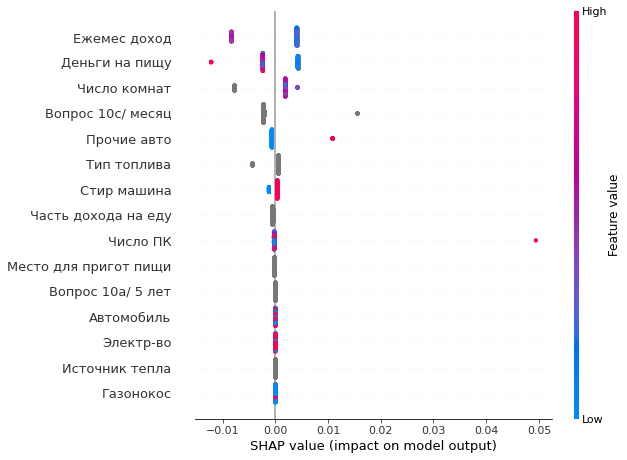

In [ ]:
target = 'Стенокардия, ИБС, инфаркт миокарда'
list_name = ['Дом хоз']
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val, True)

In [ ]:
cb_imps2

,cols,imps,imps_not_norm
25,Ежемес доход,0.005556,-0.000342
26,Деньги на пищу,0.003350,0.000049
52,Число комнат,0.003200,-0.000053
36,Вопрос 10c/ месяц,0.002733,-0.001769
9,Прочие авто,0.001257,0.000011
2,Тип топлива,0.000858,0.000141
14,Стир машина,0.000559,0.000014
48,Часть дохода на еду,0.000506,-0.000506
13,Число ПК,0.000429,-0.000017
29,Место для пригот пищи,0.000207,-0.000207


In [ ]:
new_feats = ['Ежемес доход', 'Число ПК', 'Площадь дачи', 'Площадь жилья', 
             'Готовка вне дома, месяц', 'ПК', 'Достаток по срав с друг',
              'Число авто', 'Гараж', 'Ферма']

Validate AUC (10 features) = 0.630822


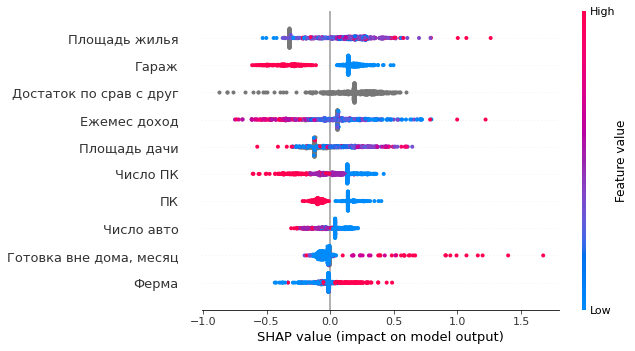

In [ ]:
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val, False)

In [ ]:
cb_imps2

,cols,imps,imps_not_norm
3,Площадь жилья,0.239348,0.038668
8,Гараж,0.238396,-0.002495
6,Достаток по срав с друг,0.231045,0.183175
0,Ежемес доход,0.206946,0.011602
2,Площадь дачи,0.158813,0.013606
1,Число ПК,0.157194,0.005117
5,ПК,0.117985,0.004554
7,Число авто,0.091663,0.003189
4,"Готовка вне дома, месяц",0.088056,-0.001983
9,Ферма,0.080984,-0.008325


In [ ]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 4

Validate AUC (54 features) = 0.522656


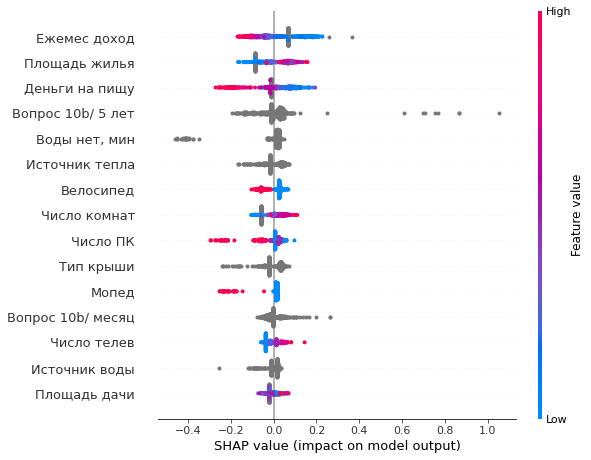

In [ ]:
target = 'Сердечная недостаточность'
list_name = ['Дом хоз']
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val, False)

In [ ]:
cb_imps2

,cols,imps,imps_not_norm
25,Ежемес доход,0.079910,0.015928
53,Площадь жилья,0.067003,-0.006031
26,Деньги на пищу,0.064588,0.001561
35,Вопрос 10b/ 5 лет,0.052198,0.008707
5,"Воды нет, мин",0.038526,-0.004590
3,Источник тепла,0.037556,0.002814
10,Велосипед,0.037426,0.001262
52,Число комнат,0.037274,-0.001840
13,Число ПК,0.037126,-0.006786
0,Тип крыши,0.036872,0.002593


In [ ]:
new_feats = ['Ежемес доход', 'Площадь жилья', 'Деньги на пищу', 'Воды нет, мин',
             'Источник тепла', 'Велосипед', 'Число комнат']

[I 2020-11-28 10:29:43,558] A new study created in memory with name: no-name-f127272b-9db0-4e5e-b044-3fd21dbf8622


Подбор параметров


[I 2020-11-28 10:29:47,825] Trial 0 finished with value: 0.5209961685823754 and parameters: {'max_depth': 1, 'n_estimators': 794, 'reg_lambda': 71.25182920875116, 'learning_rate': 0.18018279817758265, 'border_count': 56, 'random_strength': 2.3192066657340358, 'bagging_temperature': 0.7243020727743226}. Best is trial 0 with value: 0.5209961685823754.


TRAIN AUC = 0.652522
Validate AUC = 0.520996
{'random_state': 123, 'n_estimators': 794, 'task_type': 'GPU', 'bagging_temperature': 0.7243020727743226, 'eval_metric': 'AUC', 'random_strength': 2.3192066657340358, 'verbose': False, 'border_count': 56, 'loss_function': 'Logloss', 'l2_leaf_reg': 71.25182920875116, 'depth': 1, 'learning_rate': 0.18018279817758265}


[I 2020-11-28 10:29:52,772] Trial 1 finished with value: 0.5124904214559387 and parameters: {'max_depth': 1, 'n_estimators': 555, 'reg_lambda': 19.634468861888244, 'learning_rate': 0.03788666259709331, 'border_count': 27, 'random_strength': 2.896675839239642e-06, 'bagging_temperature': 0.48710484383269204}. Best is trial 0 with value: 0.5209961685823754.


TRAIN AUC = 0.564561
Validate AUC = 0.51249
{'random_state': 123, 'n_estimators': 555, 'task_type': 'GPU', 'bagging_temperature': 0.48710484383269204, 'eval_metric': 'AUC', 'random_strength': 2.896675839239642e-06, 'verbose': False, 'border_count': 27, 'loss_function': 'Logloss', 'l2_leaf_reg': 19.634468861888244, 'depth': 1, 'learning_rate': 0.03788666259709331}


[I 2020-11-28 10:30:01,641] Trial 2 finished with value: 0.523448275862069 and parameters: {'max_depth': 2, 'n_estimators': 972, 'reg_lambda': 31.003769063907516, 'learning_rate': 0.013234345357971283, 'border_count': 104, 'random_strength': 2.6190828332379107e-06, 'bagging_temperature': 0.7838470373230686}. Best is trial 2 with value: 0.523448275862069.


TRAIN AUC = 0.617938
Validate AUC = 0.523448
{'random_state': 123, 'n_estimators': 972, 'task_type': 'GPU', 'bagging_temperature': 0.7838470373230686, 'eval_metric': 'AUC', 'random_strength': 2.6190828332379107e-06, 'verbose': False, 'border_count': 104, 'loss_function': 'Logloss', 'l2_leaf_reg': 31.003769063907516, 'depth': 2, 'learning_rate': 0.013234345357971283}


[I 2020-11-28 10:30:09,625] Trial 3 finished with value: 0.5435759897828863 and parameters: {'max_depth': 5, 'n_estimators': 409, 'reg_lambda': 85.4638304421358, 'learning_rate': 0.015691015378463406, 'border_count': 243, 'random_strength': 9.199541846402308e-05, 'bagging_temperature': 0.8933149469122991}. Best is trial 3 with value: 0.5435759897828863.


TRAIN AUC = 0.598298
Validate AUC = 0.543576
{'random_state': 123, 'n_estimators': 409, 'task_type': 'GPU', 'bagging_temperature': 0.8933149469122991, 'eval_metric': 'AUC', 'random_strength': 9.199541846402308e-05, 'verbose': False, 'border_count': 243, 'loss_function': 'Logloss', 'l2_leaf_reg': 85.4638304421358, 'depth': 5, 'learning_rate': 0.015691015378463406}


[I 2020-11-28 10:30:15,517] Trial 4 finished with value: 0.503984674329502 and parameters: {'max_depth': 2, 'n_estimators': 913, 'reg_lambda': 11.866190495540351, 'learning_rate': 0.025011887639830553, 'border_count': 247, 'random_strength': 1.9942283937566015e-05, 'bagging_temperature': 0.021943954764434226}. Best is trial 3 with value: 0.5435759897828863.


TRAIN AUC = 0.561256
Validate AUC = 0.503985
{'random_state': 123, 'n_estimators': 913, 'task_type': 'GPU', 'bagging_temperature': 0.021943954764434226, 'eval_metric': 'AUC', 'random_strength': 1.9942283937566015e-05, 'verbose': False, 'border_count': 247, 'loss_function': 'Logloss', 'l2_leaf_reg': 11.866190495540351, 'depth': 2, 'learning_rate': 0.025011887639830553}


[I 2020-11-28 10:30:23,013] Trial 5 finished with value: 0.516551724137931 and parameters: {'max_depth': 5, 'n_estimators': 755, 'reg_lambda': 50.17969504840215, 'learning_rate': 0.06412577226235908, 'border_count': 61, 'random_strength': 8.776869353580089e-08, 'bagging_temperature': 0.8694682241120226}. Best is trial 3 with value: 0.5435759897828863.


TRAIN AUC = 0.637564
Validate AUC = 0.516552
{'random_state': 123, 'n_estimators': 755, 'task_type': 'GPU', 'bagging_temperature': 0.8694682241120226, 'eval_metric': 'AUC', 'random_strength': 8.776869353580089e-08, 'verbose': False, 'border_count': 61, 'loss_function': 'Logloss', 'l2_leaf_reg': 50.17969504840215, 'depth': 5, 'learning_rate': 0.06412577226235908}


[I 2020-11-28 10:30:25,566] Trial 6 finished with value: 0.512234993614304 and parameters: {'max_depth': 1, 'n_estimators': 444, 'reg_lambda': 59.266353221252885, 'learning_rate': 0.0770520575098999, 'border_count': 146, 'random_strength': 0.29363043342995643, 'bagging_temperature': 0.7458696811157994}. Best is trial 3 with value: 0.5435759897828863.


TRAIN AUC = 0.564688
Validate AUC = 0.512235
{'random_state': 123, 'n_estimators': 444, 'task_type': 'GPU', 'bagging_temperature': 0.7458696811157994, 'eval_metric': 'AUC', 'random_strength': 0.29363043342995643, 'verbose': False, 'border_count': 146, 'loss_function': 'Logloss', 'l2_leaf_reg': 59.266353221252885, 'depth': 1, 'learning_rate': 0.0770520575098999}


[I 2020-11-28 10:30:27,197] Trial 7 finished with value: 0.5159386973180077 and parameters: {'max_depth': 3, 'n_estimators': 132, 'reg_lambda': 58.382655069261034, 'learning_rate': 0.028786240606865774, 'border_count': 6, 'random_strength': 4.115771278550929, 'bagging_temperature': 0.32212630725465563}. Best is trial 3 with value: 0.5435759897828863.


TRAIN AUC = 0.517854
Validate AUC = 0.515939
{'random_state': 123, 'n_estimators': 132, 'task_type': 'GPU', 'bagging_temperature': 0.32212630725465563, 'eval_metric': 'AUC', 'random_strength': 4.115771278550929, 'verbose': False, 'border_count': 6, 'loss_function': 'Logloss', 'l2_leaf_reg': 58.382655069261034, 'depth': 3, 'learning_rate': 0.028786240606865774}


[I 2020-11-28 10:30:31,047] Trial 8 finished with value: 0.5035759897828863 and parameters: {'max_depth': 1, 'n_estimators': 518, 'reg_lambda': 7.26165118131391, 'learning_rate': 0.017446826939709465, 'border_count': 23, 'random_strength': 7.192460716005779, 'bagging_temperature': 0.0668821157209557}. Best is trial 3 with value: 0.5435759897828863.


TRAIN AUC = 0.567212
Validate AUC = 0.503576
{'random_state': 123, 'n_estimators': 518, 'task_type': 'GPU', 'bagging_temperature': 0.0668821157209557, 'eval_metric': 'AUC', 'random_strength': 7.192460716005779, 'verbose': False, 'border_count': 23, 'loss_function': 'Logloss', 'l2_leaf_reg': 7.26165118131391, 'depth': 1, 'learning_rate': 0.017446826939709465}


[I 2020-11-28 10:30:34,722] Trial 9 finished with value: 0.524316730523627 and parameters: {'max_depth': 4, 'n_estimators': 292, 'reg_lambda': 46.68727787642677, 'learning_rate': 0.14425896482930672, 'border_count': 234, 'random_strength': 0.6719855514964833, 'bagging_temperature': 0.7781549665640388}. Best is trial 3 with value: 0.5435759897828863.


TRAIN AUC = 0.561359
Validate AUC = 0.524317
{'random_state': 123, 'n_estimators': 292, 'task_type': 'GPU', 'bagging_temperature': 0.7781549665640388, 'eval_metric': 'AUC', 'random_strength': 0.6719855514964833, 'verbose': False, 'border_count': 234, 'loss_function': 'Logloss', 'l2_leaf_reg': 46.68727787642677, 'depth': 4, 'learning_rate': 0.14425896482930672}


[I 2020-11-28 10:30:36,510] Trial 10 finished with value: 0.5310089399744572 and parameters: {'max_depth': 5, 'n_estimators': 119, 'reg_lambda': 99.97914644235046, 'learning_rate': 0.010157315667007666, 'border_count': 180, 'random_strength': 0.003591217274373923, 'bagging_temperature': 0.950008108108996}. Best is trial 3 with value: 0.5435759897828863.


TRAIN AUC = 0.622169
Validate AUC = 0.531009
{'random_state': 123, 'n_estimators': 119, 'task_type': 'GPU', 'bagging_temperature': 0.950008108108996, 'eval_metric': 'AUC', 'random_strength': 0.003591217274373923, 'verbose': False, 'border_count': 180, 'loss_function': 'Logloss', 'l2_leaf_reg': 99.97914644235046, 'depth': 5, 'learning_rate': 0.010157315667007666}


[I 2020-11-28 10:30:38,017] Trial 11 finished with value: 0.5200766283524905 and parameters: {'max_depth': 5, 'n_estimators': 103, 'reg_lambda': 98.56466758773928, 'learning_rate': 0.010917676920488893, 'border_count': 195, 'random_strength': 0.0019121404847030651, 'bagging_temperature': 0.9746726058580861}. Best is trial 3 with value: 0.5435759897828863.


TRAIN AUC = 0.615005
Validate AUC = 0.520077
{'random_state': 123, 'n_estimators': 103, 'task_type': 'GPU', 'bagging_temperature': 0.9746726058580861, 'eval_metric': 'AUC', 'random_strength': 0.0019121404847030651, 'verbose': False, 'border_count': 195, 'loss_function': 'Logloss', 'l2_leaf_reg': 98.56466758773928, 'depth': 5, 'learning_rate': 0.010917676920488893}


[I 2020-11-28 10:30:44,020] Trial 12 finished with value: 0.5486334610472542 and parameters: {'max_depth': 4, 'n_estimators': 284, 'reg_lambda': 99.48237626950684, 'learning_rate': 0.01016630095652333, 'border_count': 187, 'random_strength': 0.00338371155546489, 'bagging_temperature': 0.965502079772126}. Best is trial 12 with value: 0.5486334610472542.


TRAIN AUC = 0.610191
Validate AUC = 0.548633
{'random_state': 123, 'n_estimators': 284, 'task_type': 'GPU', 'bagging_temperature': 0.965502079772126, 'eval_metric': 'AUC', 'random_strength': 0.00338371155546489, 'verbose': False, 'border_count': 187, 'loss_function': 'Logloss', 'l2_leaf_reg': 99.48237626950684, 'depth': 4, 'learning_rate': 0.01016630095652333}


[I 2020-11-28 10:30:50,540] Trial 13 finished with value: 0.5436781609195402 and parameters: {'max_depth': 4, 'n_estimators': 303, 'reg_lambda': 85.04596253945503, 'learning_rate': 0.017630523395793768, 'border_count': 210, 'random_strength': 0.002866748044677132, 'bagging_temperature': 0.5546175013249504}. Best is trial 12 with value: 0.5486334610472542.


TRAIN AUC = 0.593109
Validate AUC = 0.543678
{'random_state': 123, 'n_estimators': 303, 'task_type': 'GPU', 'bagging_temperature': 0.5546175013249504, 'eval_metric': 'AUC', 'random_strength': 0.002866748044677132, 'verbose': False, 'border_count': 210, 'loss_function': 'Logloss', 'l2_leaf_reg': 85.04596253945503, 'depth': 4, 'learning_rate': 0.017630523395793768}


[I 2020-11-28 10:30:56,666] Trial 14 finished with value: 0.5336143039591317 and parameters: {'max_depth': 4, 'n_estimators': 283, 'reg_lambda': 82.20333557593158, 'learning_rate': 0.020567553994898354, 'border_count': 199, 'random_strength': 0.014504447195825127, 'bagging_temperature': 0.5429603099607991}. Best is trial 12 with value: 0.5486334610472542.


TRAIN AUC = 0.593649
Validate AUC = 0.533614
{'random_state': 123, 'n_estimators': 283, 'task_type': 'GPU', 'bagging_temperature': 0.5429603099607991, 'eval_metric': 'AUC', 'random_strength': 0.014504447195825127, 'verbose': False, 'border_count': 199, 'loss_function': 'Logloss', 'l2_leaf_reg': 82.20333557593158, 'depth': 4, 'learning_rate': 0.020567553994898354}


[I 2020-11-28 10:31:00,636] Trial 15 finished with value: 0.5127969348659004 and parameters: {'max_depth': 4, 'n_estimators': 266, 'reg_lambda': 89.35754293724223, 'learning_rate': 0.010115202950234577, 'border_count': 147, 'random_strength': 0.046447452342179174, 'bagging_temperature': 0.1928479427926627}. Best is trial 12 with value: 0.5486334610472542.


TRAIN AUC = 0.570305
Validate AUC = 0.512797
{'random_state': 123, 'n_estimators': 266, 'task_type': 'GPU', 'bagging_temperature': 0.1928479427926627, 'eval_metric': 'AUC', 'random_strength': 0.046447452342179174, 'verbose': False, 'border_count': 147, 'loss_function': 'Logloss', 'l2_leaf_reg': 89.35754293724223, 'depth': 4, 'learning_rate': 0.010115202950234577}


[I 2020-11-28 10:31:02,584] Trial 16 finished with value: 0.5236526181353767 and parameters: {'max_depth': 3, 'n_estimators': 197, 'reg_lambda': 73.92981666290424, 'learning_rate': 0.03769600990459239, 'border_count': 218, 'random_strength': 0.00023977763098836328, 'bagging_temperature': 0.5190368248115214}. Best is trial 12 with value: 0.5486334610472542.


TRAIN AUC = 0.499657
Validate AUC = 0.523653
{'random_state': 123, 'n_estimators': 197, 'task_type': 'GPU', 'bagging_temperature': 0.5190368248115214, 'eval_metric': 'AUC', 'random_strength': 0.00023977763098836328, 'verbose': False, 'border_count': 218, 'loss_function': 'Logloss', 'l2_leaf_reg': 73.92981666290424, 'depth': 3, 'learning_rate': 0.03769600990459239}


[I 2020-11-28 10:31:09,283] Trial 17 finished with value: 0.5469220945083014 and parameters: {'max_depth': 4, 'n_estimators': 386, 'reg_lambda': 91.86452171485033, 'learning_rate': 0.013624796173834382, 'border_count': 167, 'random_strength': 0.0006437775317741871, 'bagging_temperature': 0.6180971993139867}. Best is trial 12 with value: 0.5486334610472542.


TRAIN AUC = 0.580788
Validate AUC = 0.546922
{'random_state': 123, 'n_estimators': 386, 'task_type': 'GPU', 'bagging_temperature': 0.6180971993139867, 'eval_metric': 'AUC', 'random_strength': 0.0006437775317741871, 'verbose': False, 'border_count': 167, 'loss_function': 'Logloss', 'l2_leaf_reg': 91.86452171485033, 'depth': 4, 'learning_rate': 0.013624796173834382}


[I 2020-11-28 10:31:19,643] Trial 18 finished with value: 0.5237547892720307 and parameters: {'max_depth': 3, 'n_estimators': 656, 'reg_lambda': 99.10481564023365, 'learning_rate': 0.012747509297255995, 'border_count': 164, 'random_strength': 1.5291072607008185e-09, 'bagging_temperature': 0.6366049064947198}. Best is trial 12 with value: 0.5486334610472542.


TRAIN AUC = 0.560495
Validate AUC = 0.523755
{'random_state': 123, 'n_estimators': 656, 'task_type': 'GPU', 'bagging_temperature': 0.6366049064947198, 'eval_metric': 'AUC', 'random_strength': 1.5291072607008185e-09, 'verbose': False, 'border_count': 164, 'loss_function': 'Logloss', 'l2_leaf_reg': 99.10481564023365, 'depth': 3, 'learning_rate': 0.012747509297255995}


[I 2020-11-28 10:31:24,097] Trial 19 finished with value: 0.5293997445721583 and parameters: {'max_depth': 4, 'n_estimators': 386, 'reg_lambda': 72.93453838127755, 'learning_rate': 0.06928861800303536, 'border_count': 107, 'random_strength': 0.0003811778381565003, 'bagging_temperature': 0.3907996922015965}. Best is trial 12 with value: 0.5486334610472542.


TRAIN AUC = 0.619565
Validate AUC = 0.5294
{'random_state': 123, 'n_estimators': 386, 'task_type': 'GPU', 'bagging_temperature': 0.3907996922015965, 'eval_metric': 'AUC', 'random_strength': 0.0003811778381565003, 'verbose': False, 'border_count': 107, 'loss_function': 'Logloss', 'l2_leaf_reg': 72.93453838127755, 'depth': 4, 'learning_rate': 0.06928861800303536}


[I 2020-11-28 10:31:30,815] Trial 20 finished with value: 0.5211494252873563 and parameters: {'max_depth': 2, 'n_estimators': 534, 'reg_lambda': 93.58448469111735, 'learning_rate': 0.02528614383525795, 'border_count': 110, 'random_strength': 0.04640292176316273, 'bagging_temperature': 0.6431916108732071}. Best is trial 12 with value: 0.5486334610472542.


TRAIN AUC = 0.562112
Validate AUC = 0.521149
{'random_state': 123, 'n_estimators': 534, 'task_type': 'GPU', 'bagging_temperature': 0.6431916108732071, 'eval_metric': 'AUC', 'random_strength': 0.04640292176316273, 'verbose': False, 'border_count': 110, 'loss_function': 'Logloss', 'l2_leaf_reg': 93.58448469111735, 'depth': 2, 'learning_rate': 0.02528614383525795}


[I 2020-11-28 10:31:37,212] Trial 21 finished with value: 0.5484546615581098 and parameters: {'max_depth': 4, 'n_estimators': 366, 'reg_lambda': 81.78479885160075, 'learning_rate': 0.016620955796737273, 'border_count': 213, 'random_strength': 0.0054009491874398895, 'bagging_temperature': 0.39697021054946646}. Best is trial 12 with value: 0.5486334610472542.


TRAIN AUC = 0.581747
Validate AUC = 0.548455
{'random_state': 123, 'n_estimators': 366, 'task_type': 'GPU', 'bagging_temperature': 0.39697021054946646, 'eval_metric': 'AUC', 'random_strength': 0.0054009491874398895, 'verbose': False, 'border_count': 213, 'loss_function': 'Logloss', 'l2_leaf_reg': 81.78479885160075, 'depth': 4, 'learning_rate': 0.016620955796737273}


[I 2020-11-28 10:31:45,047] Trial 22 finished with value: 0.5276883780332056 and parameters: {'max_depth': 4, 'n_estimators': 360, 'reg_lambda': 79.26748583792579, 'learning_rate': 0.01352309554855098, 'border_count': 176, 'random_strength': 1.9936326363198412e-05, 'bagging_temperature': 0.2891579218040228}. Best is trial 12 with value: 0.5486334610472542.


TRAIN AUC = 0.593626
Validate AUC = 0.527688
{'random_state': 123, 'n_estimators': 360, 'task_type': 'GPU', 'bagging_temperature': 0.2891579218040228, 'eval_metric': 'AUC', 'random_strength': 1.9936326363198412e-05, 'verbose': False, 'border_count': 176, 'loss_function': 'Logloss', 'l2_leaf_reg': 79.26748583792579, 'depth': 4, 'learning_rate': 0.01352309554855098}


[I 2020-11-28 10:31:49,464] Trial 23 finished with value: 0.5384929757343551 and parameters: {'max_depth': 4, 'n_estimators': 205, 'reg_lambda': 94.61636347001273, 'learning_rate': 0.01062218323209718, 'border_count': 143, 'random_strength': 0.0008336742058805327, 'bagging_temperature': 0.3975906338195676}. Best is trial 12 with value: 0.5486334610472542.


TRAIN AUC = 0.585747
Validate AUC = 0.538493
{'random_state': 123, 'n_estimators': 205, 'task_type': 'GPU', 'bagging_temperature': 0.3975906338195676, 'eval_metric': 'AUC', 'random_strength': 0.0008336742058805327, 'verbose': False, 'border_count': 143, 'loss_function': 'Logloss', 'l2_leaf_reg': 94.61636347001273, 'depth': 4, 'learning_rate': 0.01062218323209718}


[I 2020-11-28 10:31:55,076] Trial 24 finished with value: 0.5301404853128991 and parameters: {'max_depth': 3, 'n_estimators': 491, 'reg_lambda': 62.974078347221976, 'learning_rate': 0.020976109499379007, 'border_count': 223, 'random_strength': 0.016849813893627826, 'bagging_temperature': 0.16966374691860797}. Best is trial 12 with value: 0.5486334610472542.


TRAIN AUC = 0.621356
Validate AUC = 0.53014
{'random_state': 123, 'n_estimators': 491, 'task_type': 'GPU', 'bagging_temperature': 0.16966374691860797, 'eval_metric': 'AUC', 'random_strength': 0.016849813893627826, 'verbose': False, 'border_count': 223, 'loss_function': 'Logloss', 'l2_leaf_reg': 62.974078347221976, 'depth': 3, 'learning_rate': 0.020976109499379007}
Validate AUC (7 features) = 0.540945


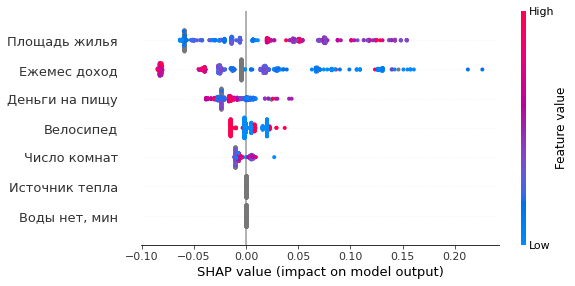

In [ ]:
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val, True)

In [ ]:
new_feats = ['Ежемес доход', 'Площадь жилья', 'Деньги на пищу',
             'Велосипед', 'Число комнат']
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)

Validate AUC (5 features) = 0.536782


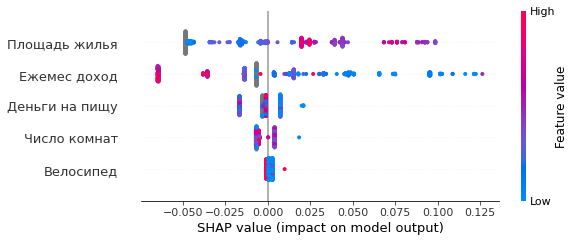

In [ ]:
cb.fit(train_pool, eval_set=val_pool, early_stopping_rounds=150, verbose=0)
print(f"Validate AUC ({len(X_val.columns)} features) = {roc_auc_score(val_pool.get_label(), cb.predict_proba(val_pool)[:,1]):.6}")
imps = cb.get_feature_importance(val_pool, type='ShapValues')
cb_imps2 = pd.DataFrame({'cols':train_pool.get_feature_names(), 'imps': np.mean(np.abs(imps),axis=0)[:-1],
                        'imps_not_norm': np.mean((imps),axis=0)[:-1]}).sort_values(by=['imps'],\
                                                                                                ascending=False)
shap_values = cb.get_feature_importance(val_pool, type='ShapValues')[:,:-1]
shap.summary_plot(shap_values, X_val, max_display=15)

In [ ]:
cb_imps2

,cols,imps,imps_not_norm
1,Площадь жилья,0.036681,0.001045
0,Ежемес доход,0.033270,-0.000299
2,Деньги на пищу,0.006952,-0.002795
4,Число комнат,0.005743,-0.003544
3,Велосипед,0.001309,0.000929


In [ ]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 5

Validate AUC (54 features) = 0.63848


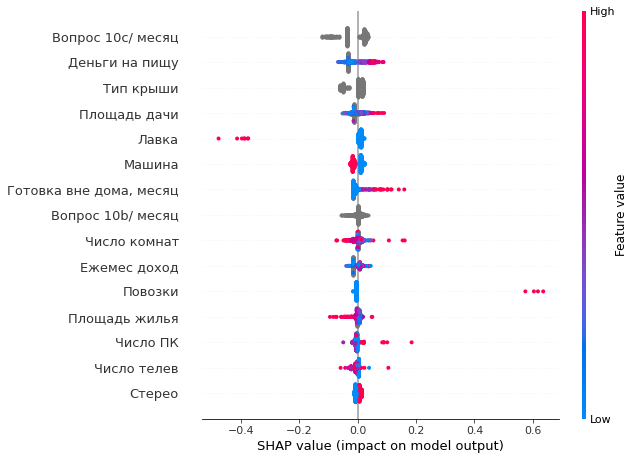

In [ ]:
target = 'Прочие заболевания сердца'
list_name = ['Дом хоз']
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val, False)

In [ ]:
cb_imps2

,cols,imps,imps_not_norm
36,Вопрос 10c/ месяц,0.032750,0.000102
26,Деньги на пищу,0.031679,-0.000705
0,Тип крыши,0.017795,0.000212
28,Площадь дачи,0.016888,-0.002210
45,Лавка,0.015153,0.003432
42,Машина,0.014195,0.000635
31,"Готовка вне дома, месяц",0.013242,-0.003817
34,Вопрос 10b/ месяц,0.010385,0.001570
52,Число комнат,0.010316,0.000753
25,Ежемес доход,0.009914,-0.000037


In [ ]:
new_feats = [
             'Готовка вне дома, месяц', 'Число комнат', 'Ежемес доход',
             'Площадь жилья']

Validate AUC (4 features) = 0.615506


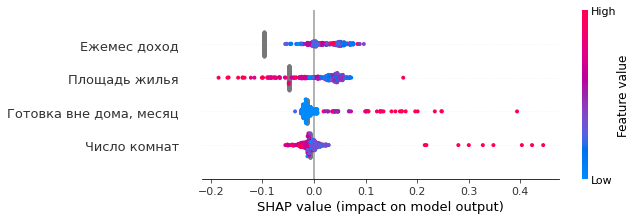

In [ ]:
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val, False)

In [ ]:
cb_imps2

,cols,imps,imps_not_norm
2,Ежемес доход,0.044103,-0.001054
3,Площадь жилья,0.042238,0.003800
0,"Готовка вне дома, месяц",0.021285,-0.000513
1,Число комнат,0.017867,-0.001707


In [ ]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

### Оценка терр

In [9]:
target = 'Артериальная гипертензия'
list_name = ['Оценка терр']

Validate AUC (39 features) = 0.62628


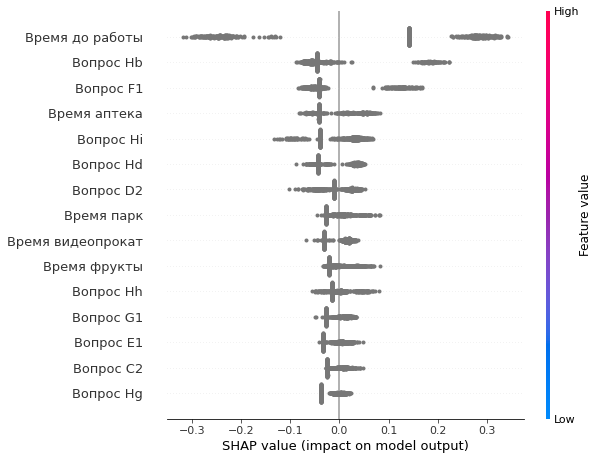

In [10]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [11]:
cb_imps2

,cols,imps,imps_not_norm
7,Время до работы,0.234735,0.053372
30,Вопрос Hb,0.073618,-0.006191
23,Вопрос F1,0.067472,-0.005622
6,Время аптека,0.041746,-0.005399
37,Вопрос Hi,0.040322,0.001211
32,Вопрос Hd,0.039139,0.000626
18,Вопрос D2,0.028303,-0.005043
9,Время парк,0.021208,0.001292
5,Время видеопрокат,0.020910,0.003293
2,Время фрукты,0.020638,0.001995


Validate AUC (10 features) = 0.635365


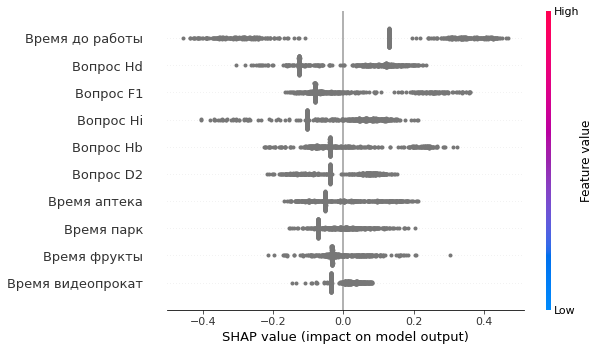

In [12]:
new_feats = ['Время до работы','Вопрос Hb', 'Вопрос F1',
'Время аптека', 'Вопрос Hi', 'Вопрос Hd', 'Вопрос D2', 'Время парк', 'Время видеопрокат', 'Время фрукты'	]
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [14]:
cb_imps2

,cols,imps,imps_not_norm
0,Время до работы,0.279727,0.054737
5,Вопрос Hd,0.121981,0.011533
2,Вопрос F1,0.109488,0.002225
4,Вопрос Hi,0.100202,-0.009814
1,Вопрос Hb,0.090411,0.002011
6,Вопрос D2,0.080753,-0.013058
3,Время аптека,0.075172,-0.001485
7,Время парк,0.052863,-0.011506
9,Время фрукты,0.046926,-0.010737
8,Время видеопрокат,0.031666,0.009143


In [15]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 2

In [16]:
target = 'ОНМК'
list_name = ['Оценка терр']

Validate AUC (39 features) = 0.72587


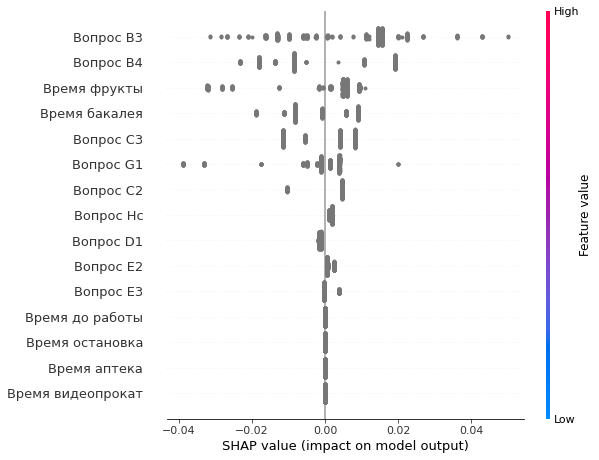

In [17]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [18]:
cb_imps2

,cols,imps,imps_not_norm
12,Вопрос B3,0.014923,0.006848
13,Вопрос B4,0.014104,-0.001923
2,Время фрукты,0.009333,-0.000306
0,Время бакалея,0.007717,-0.001952
16,Вопрос C3,0.007716,-0.000221
26,Вопрос G1,0.005887,-0.002705
15,Вопрос C2,0.005805,0.001875
31,Вопрос Hc,0.001669,0.001669
17,Вопрос D1,0.001272,-0.001272
21,Вопрос E2,0.001097,0.001097


Validate AUC (9 features) = 0.76788


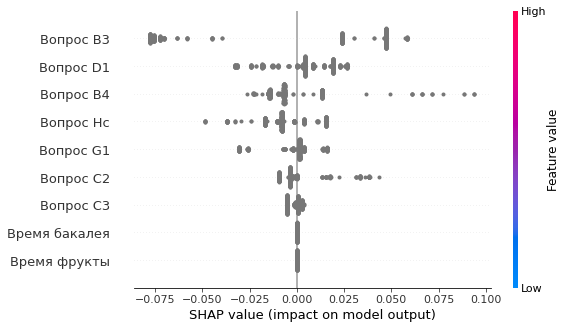

In [20]:
new_feats = ['Вопрос B3', 'Вопрос B4', 'Время фрукты', 'Время бакалея', 
             'Вопрос C3', 'Вопрос G1', 'Вопрос C2', 'Вопрос Hc', 'Вопрос D1']
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [21]:
cb_imps2

,cols,imps,imps_not_norm
0,Вопрос B3,0.053876,-0.005859
8,Вопрос D1,0.013632,0.003191
1,Вопрос B4,0.012705,-0.002075
7,Вопрос Hc,0.012126,-0.005244
5,Вопрос G1,0.009719,-0.002503
6,Вопрос C2,0.007633,0.000365
4,Вопрос C3,0.002457,-0.001007
3,Время бакалея,0.000054,-0.000054
2,Время фрукты,0.000020,-0.000020


In [22]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 3

In [23]:
target = 'Стенокардия, ИБС, инфаркт миокарда'
list_name = ['Оценка терр']

Validate AUC (39 features) = 0.602098


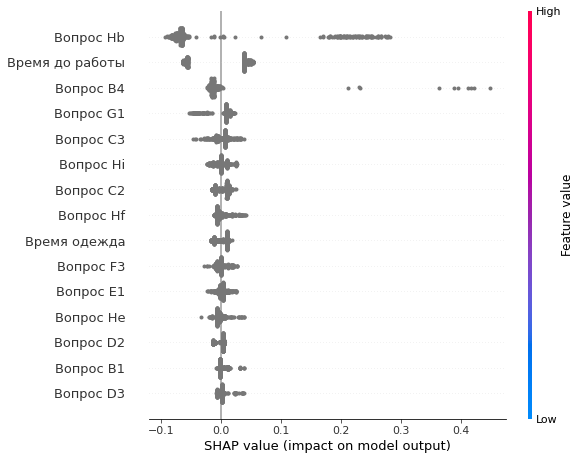

In [24]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [25]:
cb_imps2

,cols,imps,imps_not_norm
30,Вопрос Hb,0.099539,-0.009014
7,Время до работы,0.048928,-0.001235
13,Вопрос B4,0.020443,-0.005769
26,Вопрос G1,0.015393,0.002881
16,Вопрос C3,0.009661,0.001554
37,Вопрос Hi,0.009361,-0.001134
15,Вопрос C2,0.009144,0.002891
34,Вопрос Hf,0.009005,0.000796
1,Время одежда,0.007992,0.001570
25,Вопрос F3,0.006855,-0.000220


Validate AUC (10 features) = 0.618201


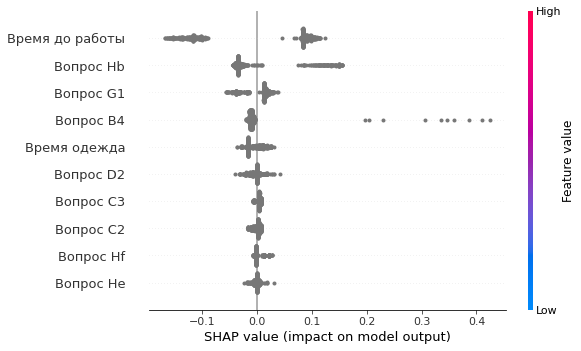

In [34]:
new_feats = ['Вопрос Hb', 'Время до работы', 'Вопрос B4', 'Вопрос G1', 'Вопрос C3' 
, 'Вопрос C2', 'Вопрос Hf', 'Время одежда',  'Вопрос He',	'Вопрос D2']
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [35]:
cb_imps2

,cols,imps,imps_not_norm
1,Время до работы,0.104256,-0.000289
0,Вопрос Hb,0.051803,-0.000985
3,Вопрос G1,0.020999,0.003277
2,Вопрос B4,0.016836,-0.003497
7,Время одежда,0.011620,0.000092
9,Вопрос D2,0.007431,-0.002895
4,Вопрос C3,0.005249,0.004159
5,Вопрос C2,0.004994,-0.000028
6,Вопрос Hf,0.003673,0.000700
8,Вопрос He,0.003200,-0.000494


In [36]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 4

In [37]:
target = 'Сердечная недостаточность'
list_name = ['Оценка терр']

Validate AUC (39 features) = 0.691188


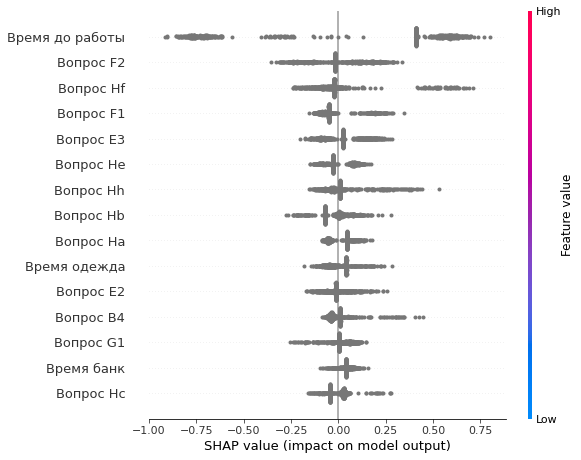

In [38]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [39]:
cb_imps2

,cols,imps,imps_not_norm
7,Время до работы,0.570455,0.042243
24,Вопрос F2,0.128198,0.000025
34,Вопрос Hf,0.115198,0.008683
23,Вопрос F1,0.098925,-0.004475
22,Вопрос E3,0.096716,0.024757
33,Вопрос He,0.071919,0.010061
36,Вопрос Hh,0.071740,0.021499
30,Вопрос Hb,0.062135,-0.011793
29,Вопрос Ha,0.059012,-0.001103
1,Время одежда,0.057684,0.003026


Validate AUC (11 features) = 0.684828


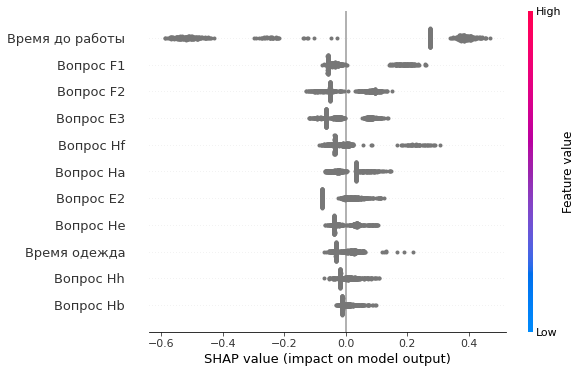

In [47]:
new_feats = ['Время до работы',
'Вопрос F2','Вопрос Hf',
'Вопрос F1','Вопрос E3','Вопрос He',
'Вопрос Hh','Вопрос Hb', 
'Вопрос Ha', 'Время одежда',
'Вопрос E2'] 
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [48]:
cb_imps2

,cols,imps,imps_not_norm
0,Время до работы,0.392269,0.014185
3,Вопрос F1,0.081323,0.016471
1,Вопрос F2,0.072519,0.005763
4,Вопрос E3,0.063677,-0.007859
2,Вопрос Hf,0.050030,0.002644
8,Вопрос Ha,0.042507,0.006069
10,Вопрос E2,0.039094,0.001797
5,Вопрос He,0.037315,0.001433
9,Время одежда,0.029459,0.001862
6,Вопрос Hh,0.022489,0.005944


In [49]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 5

In [50]:
target = 'Прочие заболевания сердца'
list_name = ['Оценка терр']

Validate AUC (39 features) = 0.584755


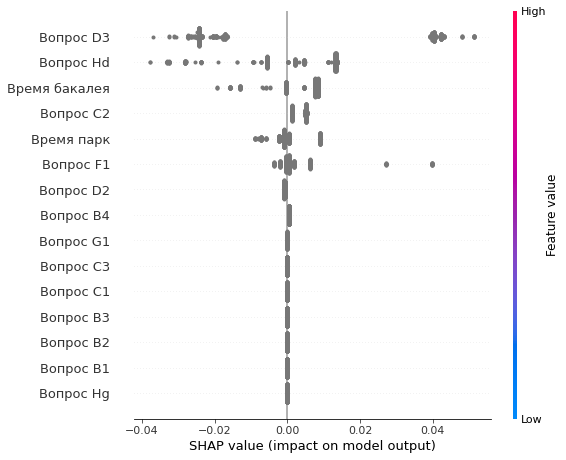

In [51]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [52]:
cb_imps2

,cols,imps,imps_not_norm
19,Вопрос D3,0.029816,0.000874
32,Вопрос Hd,0.011247,0.000678
0,Время бакалея,0.006889,0.003850
15,Вопрос C2,0.004327,0.004327
9,Время парк,0.003429,0.000585
23,Вопрос F1,0.003341,0.002461
18,Вопрос D2,0.000813,-0.000813
13,Вопрос B4,0.000465,0.000465
26,Вопрос G1,0.000107,-0.000107
16,Вопрос C3,0.000035,0.000035


Validate AUC (8 features) = 0.630868


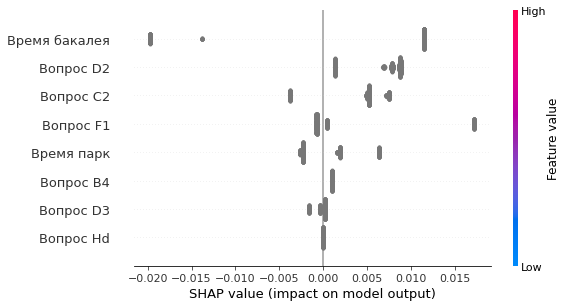

In [53]:
new_feats = ['Вопрос D3',
'Вопрос Hd',
'Время бакалея',
'Вопрос C2',
'Время парк',
'Вопрос F1',
'Вопрос D2',
'Вопрос B4'] 
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [54]:
cb_imps2

,cols,imps,imps_not_norm
2,Время бакалея,0.014189,0.001047
6,Вопрос D2,0.006892,0.006892
3,Вопрос C2,0.005410,0.003825
5,Вопрос F1,0.004970,0.004199
4,Время парк,0.003090,0.000562
7,Вопрос B4,0.001041,0.001041
0,Вопрос D3,0.000555,-0.000262
1,Вопрос Hd,0.000000,0.000000


In [55]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

### Физич акт

In [92]:
target = 'Артериальная гипертензия'
list_name = ['Физич акт']

Validate AUC (42 features) = 0.681207


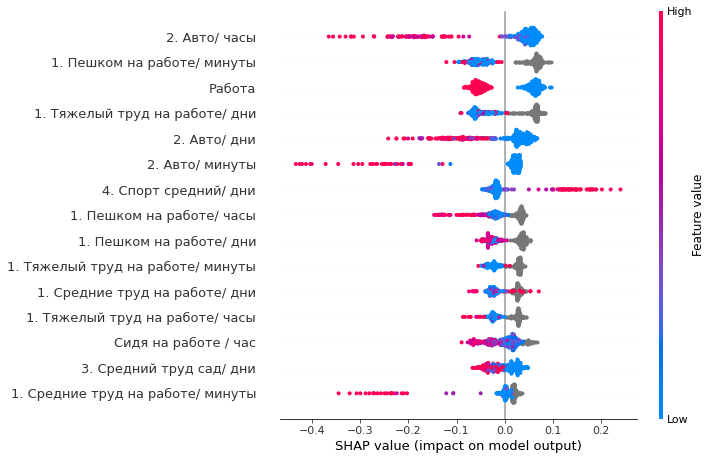

In [58]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [59]:
cb_imps2

,cols,imps,imps_not_norm
12,2. Авто/ часы,0.071556,0.011409
10,1. Пешком на работе/ минуты,0.058897,0.003970
1,Работа,0.058075,0.003458
2,1. Тяжелый труд на работе/ дни,0.055797,0.004543
11,2. Авто/ дни,0.052500,0.000754
13,2. Авто/ минуты,0.041150,0.001801
35,4. Спорт средний/ дни,0.032924,-0.002683
9,1. Пешком на работе/ часы,0.031902,-0.000446
8,1. Пешком на работе/ дни,0.031287,0.003160
4,1. Тяжелый труд на работе/ минуты,0.026276,0.001481


Validate AUC (9 features) = 0.66957


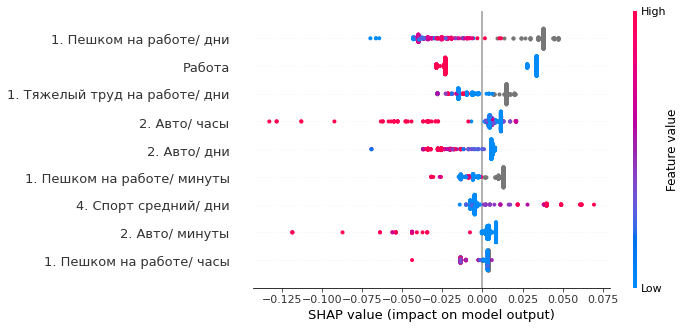

In [66]:
new_feats = ['2. Авто/ часы', 
'1. Пешком на работе/ минуты',
'Работа', 	
'1. Тяжелый труд на работе/ дни', 
'2. Авто/ дни',
'2. Авто/ минуты',
'4. Спорт средний/ дни',
'1. Пешком на работе/ часы',
'1. Пешком на работе/ дни'
]
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [67]:
cb_imps2

,cols,imps,imps_not_norm
8,1. Пешком на работе/ дни,0.035073,0.002178
2,Работа,0.028436,0.004164
3,1. Тяжелый труд на работе/ дни,0.013467,0.001053
0,2. Авто/ часы,0.012291,0.002976
4,2. Авто/ дни,0.010941,-0.002282
1,1. Пешком на работе/ минуты,0.010589,0.001471
6,4. Спорт средний/ дни,0.009296,-0.000350
5,2. Авто/ минуты,0.008939,0.001614
7,1. Пешком на работе/ часы,0.005154,-0.000334


In [68]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 2

In [69]:
target = 'ОНМК'

Validate AUC (42 features) = 0.65413


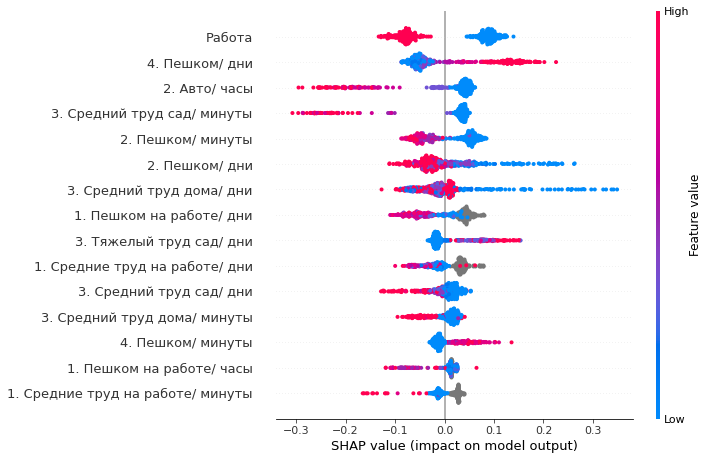

In [70]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [71]:
cb_imps2

,cols,imps,imps_not_norm
1,Работа,0.084729,0.002870
29,4. Пешком/ дни,0.071138,0.001539
12,2. Авто/ часы,0.065178,-0.000991
25,3. Средний труд сад/ минуты,0.057872,0.005441
19,2. Пешком/ минуты,0.049860,0.005154
17,2. Пешком/ дни,0.047844,0.003428
26,3. Средний труд дома/ дни,0.044683,0.005380
8,1. Пешком на работе/ дни,0.043982,-0.001009
20,3. Тяжелый труд сад/ дни,0.031762,0.007326
5,1. Средние труд на работе/ дни,0.030843,0.004052


Validate AUC (9 features) = 0.690217


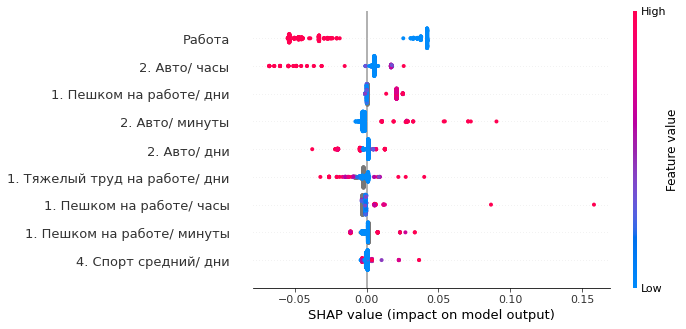

In [72]:
# new_feats = ['Вопрос B3', 'Вопрос B4', 'Время фрукты', 'Время бакалея', 
#              'Вопрос C3', 'Вопрос G1', 'Вопрос C2', 'Вопрос Hc', 'Вопрос D1']
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [73]:
cb_imps2

,cols,imps,imps_not_norm
2,Работа,0.042247,-0.002649
0,2. Авто/ часы,0.010826,0.001353
8,1. Пешком на работе/ дни,0.007310,0.007244
5,2. Авто/ минуты,0.004217,0.000398
4,2. Авто/ дни,0.003410,-0.000936
3,1. Тяжелый труд на работе/ дни,0.003291,-0.002179
7,1. Пешком на работе/ часы,0.002708,-0.000881
1,1. Пешком на работе/ минуты,0.002450,0.000055
6,4. Спорт средний/ дни,0.001474,0.000146


In [74]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 3

In [75]:
target = 'Стенокардия, ИБС, инфаркт миокарда'
# list_name = ['Оценка терр']

Validate AUC (42 features) = 0.634224


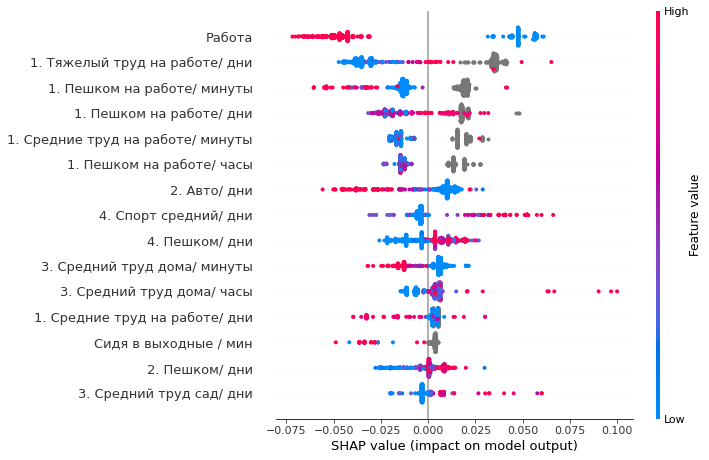

In [76]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [77]:
cb_imps2

,cols,imps,imps_not_norm
1,Работа,0.049029,-0.003313
2,1. Тяжелый труд на работе/ дни,0.033179,-0.000474
10,1. Пешком на работе/ минуты,0.018685,-0.000942
8,1. Пешком на работе/ дни,0.018016,-0.000272
7,1. Средние труд на работе/ минуты,0.016946,0.000175
9,1. Пешком на работе/ часы,0.014730,-0.000450
11,2. Авто/ дни,0.014379,0.001630
35,4. Спорт средний/ дни,0.009222,0.000115
29,4. Пешком/ дни,0.009173,-0.000241
28,3. Средний труд дома/ минуты,0.008706,0.000253


Validate AUC (9 features) = 0.630219


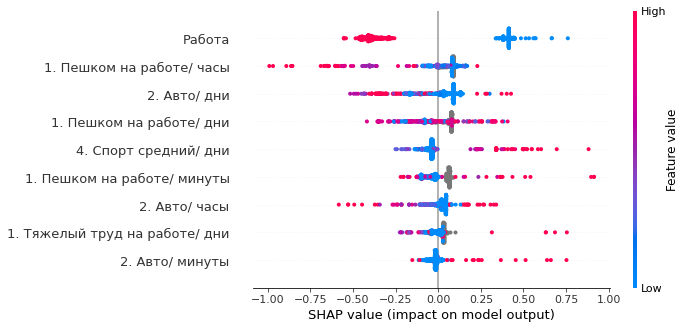

In [78]:
# new_feats = ['Вопрос Hb', 'Время до работы', 'Вопрос B4', 'Вопрос G1', 'Вопрос C3' 
# , 'Вопрос C2', 'Вопрос Hf', 'Время одежда',  'Вопрос He',	'Вопрос D2']
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [79]:
cb_imps2

,cols,imps,imps_not_norm
2,Работа,0.403449,-0.021569
7,1. Пешком на работе/ часы,0.130492,-0.014548
4,2. Авто/ дни,0.116279,-0.011044
8,1. Пешком на работе/ дни,0.105521,0.002902
6,4. Спорт средний/ дни,0.089525,0.000479
1,1. Пешком на работе/ минуты,0.070400,0.012411
0,2. Авто/ часы,0.051907,0.012139
3,1. Тяжелый труд на работе/ дни,0.037409,0.003582
5,2. Авто/ минуты,0.032427,-0.009736


In [80]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 4

In [81]:
target = 'Сердечная недостаточность'
# list_name = ['Оценка терр']

Validate AUC (42 features) = 0.599157


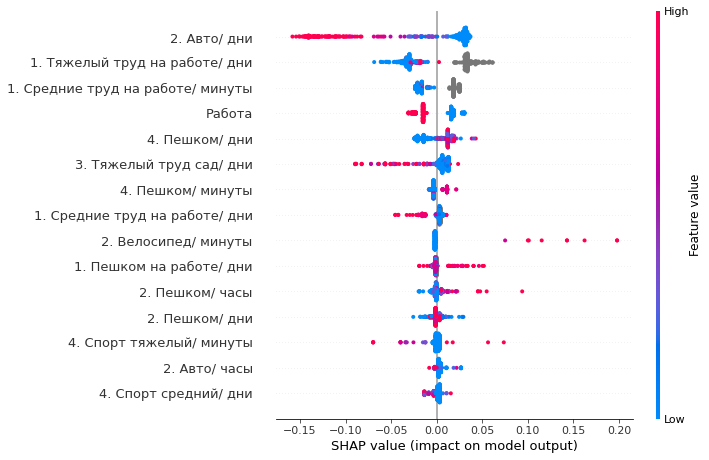

In [82]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [83]:
cb_imps2

,cols,imps,imps_not_norm
11,2. Авто/ дни,0.048229,-0.006788
2,1. Тяжелый труд на работе/ дни,0.032938,-0.000914
7,1. Средние труд на работе/ минуты,0.019003,-0.000582
1,Работа,0.017989,-0.001291
29,4. Пешком/ дни,0.014198,0.000555
20,3. Тяжелый труд сад/ дни,0.011908,0.001210
31,4. Пешком/ минуты,0.005364,-0.000043
5,1. Средние труд на работе/ дни,0.004812,-0.000080
16,2. Велосипед/ минуты,0.004373,0.000773
8,1. Пешком на работе/ дни,0.003544,-0.000008


In [85]:
new_feats

['2. Авто/ часы',
 '1. Пешком на работе/ минуты',
 'Работа',
 '1. Тяжелый труд на работе/ дни',
 '2. Авто/ дни',
 '2. Авто/ минуты',
 '4. Спорт средний/ дни',
 '1. Пешком на работе/ часы',
 '1. Пешком на работе/ дни']

Validate AUC (3 features) = 0.644189


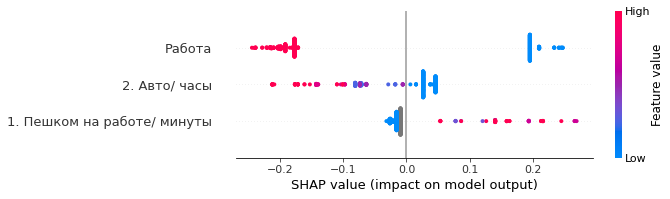

In [86]:
new_feats = ['2. Авто/ часы',
 '1. Пешком на работе/ минуты',
 'Работа',] 
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [87]:
cb_imps2

,cols,imps,imps_not_norm
2,Работа,0.193380,-0.010108
0,2. Авто/ часы,0.050589,-0.000037
1,1. Пешком на работе/ минуты,0.029139,0.003263


In [88]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 5

In [93]:
target = 'Прочие заболевания сердца'
# list_name = ['Оценка терр']

Validate AUC (42 features) = 0.641869


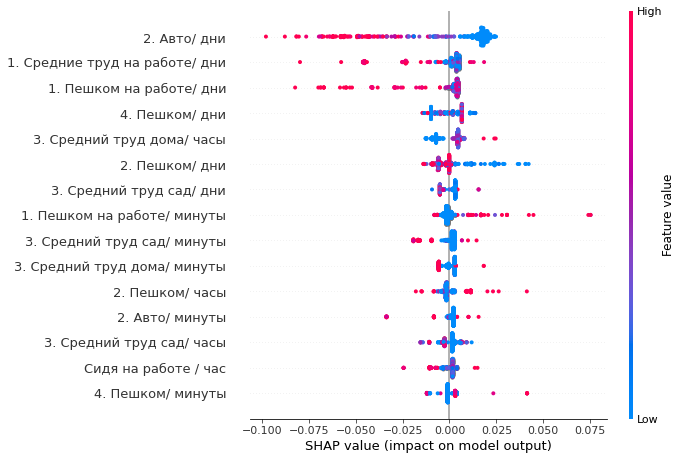

In [94]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [95]:
cb_imps2

,cols,imps,imps_not_norm
11,2. Авто/ дни,0.023857,1.444942e-03
5,1. Средние труд на работе/ дни,0.007228,-1.183972e-03
8,1. Пешком на работе/ дни,0.006680,-3.230569e-04
29,4. Пешком/ дни,0.006222,-2.672818e-04
27,3. Средний труд дома/ часы,0.005868,6.540907e-04
17,2. Пешком/ дни,0.005291,5.759039e-05
23,3. Средний труд сад/ дни,0.003715,1.367501e-04
10,1. Пешком на работе/ минуты,0.003374,8.125158e-04
25,3. Средний труд сад/ минуты,0.003298,4.009887e-05
28,3. Средний труд дома/ минуты,0.003265,9.085603e-05


Validate AUC (10 features) = 0.646841


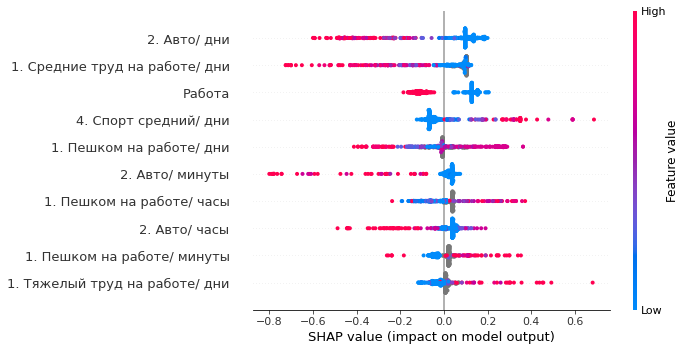

In [110]:
new_feats = ['2. Авто/ часы',
 '1. Пешком на работе/ минуты',
 'Работа',
 '1. Тяжелый труд на работе/ дни',
 '2. Авто/ дни',
 '2. Авто/ минуты',
 '4. Спорт средний/ дни',
 '1. Пешком на работе/ часы',
 '1. Пешком на работе/ дни',
 '1. Средние труд на работе/ дни'
] 
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [111]:
cb_imps2

,cols,imps,imps_not_norm
4,2. Авто/ дни,0.172020,-0.005264
9,1. Средние труд на работе/ дни,0.130256,-0.001589
2,Работа,0.122858,0.010115
6,4. Спорт средний/ дни,0.094954,0.003437
8,1. Пешком на работе/ дни,0.088074,-0.003324
5,2. Авто/ минуты,0.062501,-0.011717
7,1. Пешком на работе/ часы,0.060471,0.010574
0,2. Авто/ часы,0.059373,0.008752
1,1. Пешком на работе/ минуты,0.043032,0.006336
3,1. Тяжелый труд на работе/ дни,0.037950,0.003399


In [112]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

### Питание 1

In [113]:
target = 'Артериальная гипертензия'
list_name = ['Питание']

Validate AUC (184 features) = 0.673333


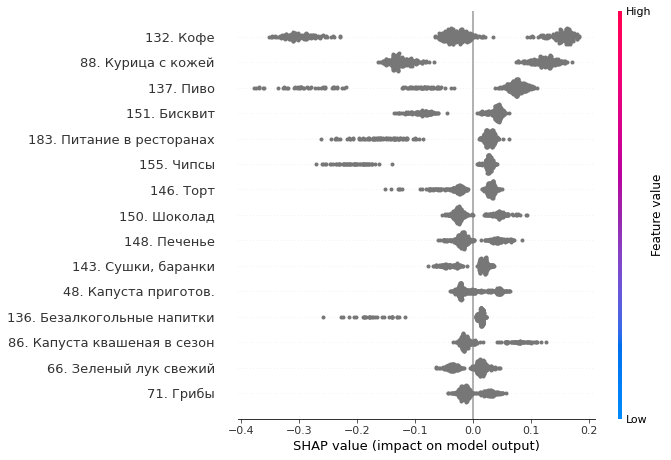

In [114]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [120]:
cb_imps2[cb_imps2.imps>0.02]['cols']

131                       132. Кофе
87               88. Курица с кожей
136                       137. Пиво
150                    151. Бисквит
182       183. Питание в ресторанах
154                      155. Чипсы
145                       146. Торт
149                    150. Шоколад
147                    148. Печенье
142             143. Сушки, баранки
47            48. Капуста приготов.
135     136. Безалкогольные напитки
85     86. Капуста квашеная в сезон
65           66. Зеленый лук свежий
Name: cols, dtype: object

Validate AUC (14 features) = 0.672079


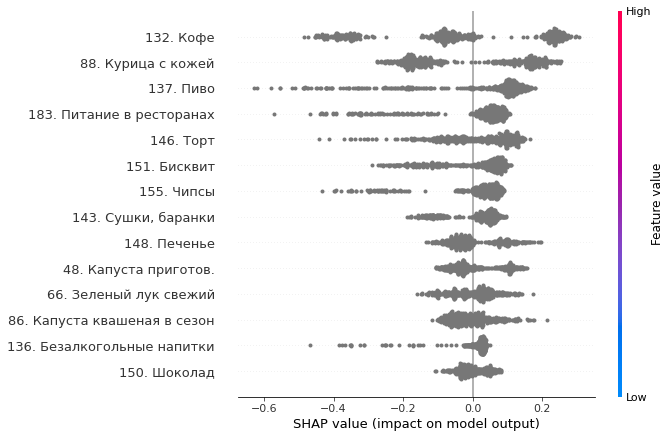

In [121]:
new_feats = list(cb_imps2[cb_imps2.imps>0.02]['cols'])
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [122]:
cb_imps2

,cols,imps,imps_not_norm
0,132. Кофе,0.197574,-0.045775
1,88. Курица с кожей,0.161526,-0.015442
2,137. Пиво,0.142358,0.017197
4,183. Питание в ресторанах,0.093185,0.000331
6,146. Торт,0.088529,0.010431
3,151. Бисквит,0.087594,-0.008744
5,155. Чипсы,0.072051,0.002932
9,"143. Сушки, баранки",0.062934,0.002555
8,148. Печенье,0.058113,0.001032
10,48. Капуста приготов.,0.057284,0.002491


In [123]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 2

In [124]:
target = 'ОНМК'

Validate AUC (184 features) = 0.554783


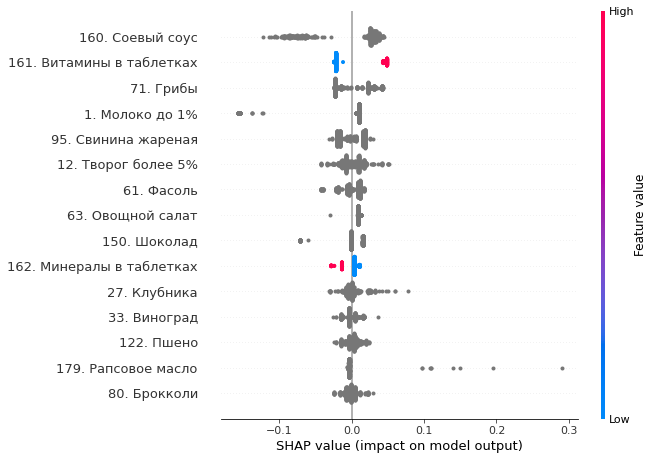

In [125]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [126]:
cb_imps2

,cols,imps,imps_not_norm
159,160. Соевый соус,0.044612,-0.003778
160,161. Витамины в таблетках,0.030064,0.000648
70,71. Грибы,0.023538,0.001923
0,1. Молоко до 1%,0.018669,-0.000964
94,95. Свинина жареная,0.015190,-0.000296
...,...,...,...
30,31. Яблоко,0.000000,0.000000
31,32. Грейпфрут,0.000000,0.000000
89,90. Мясо в сложном блюде,0.000000,0.000000
87,88. Курица с кожей,0.000000,0.000000


Validate AUC (14 features) = 0.577717


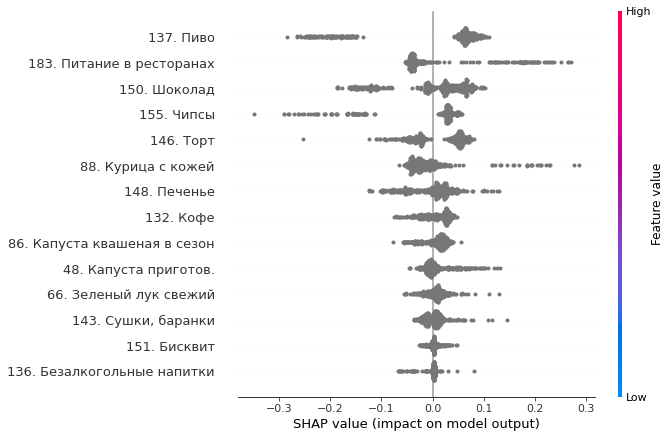

In [127]:
# new_feats = ['Вопрос B3', 'Вопрос B4', 'Время фрукты', 'Время бакалея', 
#              'Вопрос C3', 'Вопрос G1', 'Вопрос C2', 'Вопрос Hc', 'Вопрос D1']
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [128]:
cb_imps2

,cols,imps,imps_not_norm
2,137. Пиво,0.099242,0.006461
4,183. Питание в ресторанах,0.056516,-0.005742
7,150. Шоколад,0.054074,0.004602
5,155. Чипсы,0.052293,0.002431
6,146. Торт,0.046896,0.013009
1,88. Курица с кожей,0.032209,-0.009342
8,148. Печенье,0.031146,-0.000390
0,132. Кофе,0.022196,0.008014
12,86. Капуста квашеная в сезон,0.019000,0.007902
10,48. Капуста приготов.,0.016380,0.006337


In [129]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 3

In [130]:
target = 'Стенокардия, ИБС, инфаркт миокарда'
# list_name = ['Оценка терр']

Validate AUC (184 features) = 0.573534


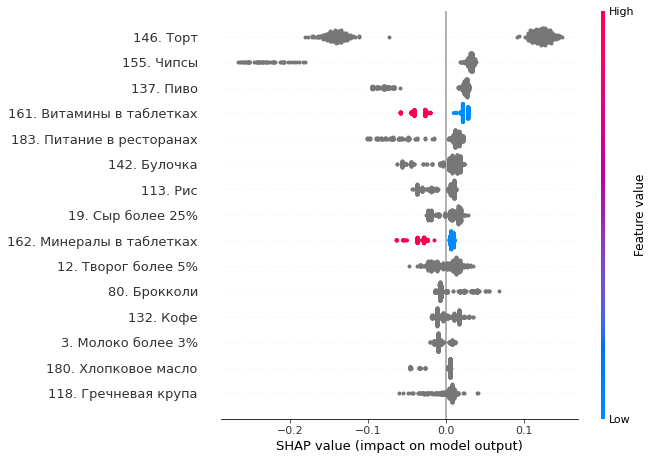

In [131]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [132]:
cb_imps2

,cols,imps,imps_not_norm
145,146. Торт,0.130238,0.008999
154,155. Чипсы,0.054262,0.001236
136,137. Пиво,0.036910,0.000807
160,161. Витамины в таблетках,0.027438,0.003706
182,183. Питание в ресторанах,0.021913,0.000839
...,...,...,...
62,63. Овощной салат,0.000000,0.000000
59,60. Бобы,0.000000,0.000000
56,"57. Петрушка, укроп",0.000000,0.000000
52,53. Свекла,0.000000,0.000000


In [134]:
new_feats

['132. Кофе',
 '88. Курица с кожей',
 '137. Пиво',
 '151. Бисквит',
 '183. Питание в ресторанах',
 '155. Чипсы',
 '146. Торт',
 '150. Шоколад',
 '148. Печенье',
 '143. Сушки, баранки',
 '48. Капуста приготов.',
 '136. Безалкогольные напитки',
 '86. Капуста квашеная в сезон',
 '66. Зеленый лук свежий']

In [136]:
new_feats = ['132. Кофе',
 '88. Курица с кожей',
 '137. Пиво',
 '151. Бисквит',
 '183. Питание в ресторанах',
 '155. Чипсы',
 '146. Торт',
 '150. Шоколад',
 '148. Печенье',
 '143. Сушки, баранки',
 '48. Капуста приготов.',
 '66. Зеленый лук свежий']

Validate AUC (12 features) = 0.582914


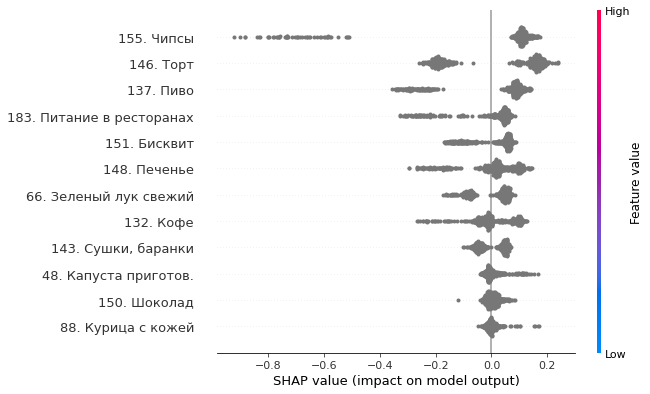

In [137]:
# new_feats = ['Вопрос Hb', 'Время до работы', 'Вопрос B4', 'Вопрос G1', 'Вопрос C3' 
# , 'Вопрос C2', 'Вопрос Hf', 'Время одежда',  'Вопрос He',	'Вопрос D2']
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [138]:
cb_imps2

,cols,imps,imps_not_norm
5,155. Чипсы,0.179254,0.018951
6,146. Торт,0.169900,0.009619
2,137. Пиво,0.129667,0.010403
4,183. Питание в ресторанах,0.072507,-0.001652
3,151. Бисквит,0.071024,0.007213
8,148. Печенье,0.069689,0.001666
11,66. Зеленый лук свежий,0.061253,0.000980
0,132. Кофе,0.055677,0.001939
9,"143. Сушки, баранки",0.046375,-0.000954
10,48. Капуста приготов.,0.020512,0.003539


In [139]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 4

In [140]:
target = 'Сердечная недостаточность'
# list_name = ['Оценка терр']

Validate AUC (184 features) = 0.633308


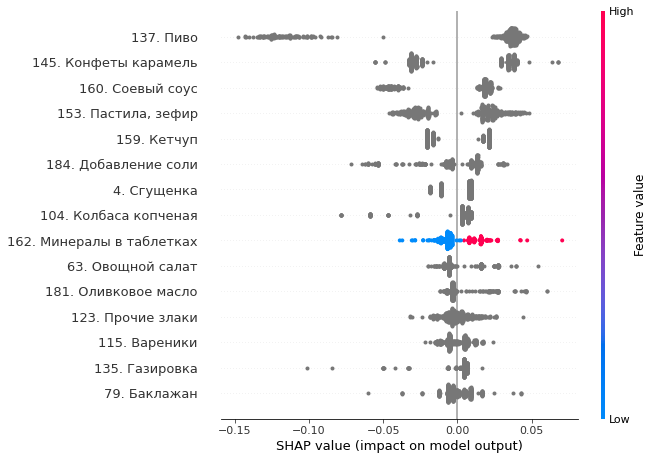

In [141]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [142]:
cb_imps2

,cols,imps,imps_not_norm
136,137. Пиво,0.056666,-0.001344
144,145. Конфеты карамель,0.032836,0.001721
159,160. Соевый соус,0.027464,-0.001490
152,"153. Пастила, зефир",0.025740,0.000822
158,159. Кетчуп,0.019535,-0.001330
...,...,...,...
76,77. Горох конс.,0.000000,0.000000
75,76. Кукуруза,0.000000,0.000000
74,75. Тыква,0.000000,0.000000
71,72. Капуста квашеная,0.000000,0.000000


In [154]:
new_feats = ['155. Чипсы', 
'137. Пиво', 
'146. Торт', 
'183. Питание в ресторанах', 
'132. Кофе', 
'148. Печенье', 
'151. Бисквит', 
'88. Курица с кожей']

Validate AUC (8 features) = 0.648582


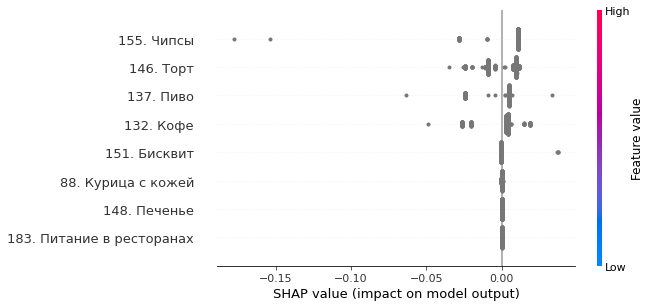

In [155]:
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [156]:
cb_imps2

,cols,imps,imps_not_norm
0,155. Чипсы,0.013501,0.006475
2,146. Торт,0.009994,0.000585
1,137. Пиво,0.008806,-0.000885
4,132. Кофе,0.008266,0.000100
6,151. Бисквит,0.000591,0.000036
7,88. Курица с кожей,0.000086,0.000070
3,183. Питание в ресторанах,0.000000,0.000000
5,148. Печенье,0.000000,0.000000


In [157]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 5

In [158]:
target = 'Прочие заболевания сердца'
# list_name = ['Оценка терр']

Validate AUC (184 features) = 0.50575


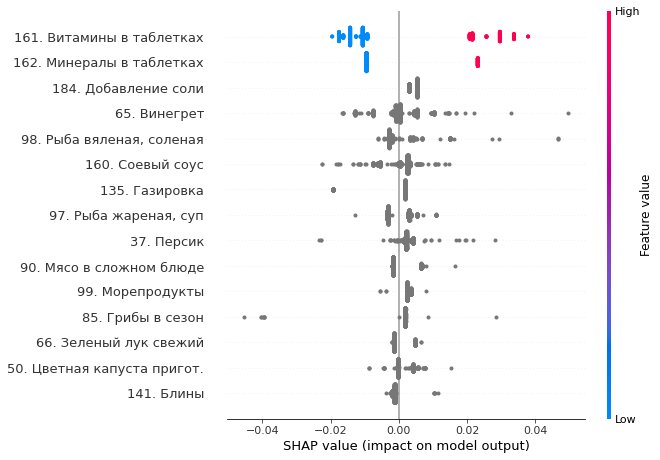

In [159]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [160]:
cb_imps2

,cols,imps,imps_not_norm
160,161. Витамины в таблетках,0.017849,0.000234
161,162. Минералы в таблетках,0.013545,0.000261
183,184. Добавление соли,0.004615,0.004615
64,65. Винегрет,0.004106,0.000111
97,"98. Рыба вяленая, соленая",0.003976,-0.000045
...,...,...,...
66,67. Зеленый лук пригот.,0.000000,0.000000
67,68. Томаты свежие,0.000000,0.000000
68,69. Томаты пригот.,0.000000,0.000000
69,70. Перец пригот.,0.000000,0.000000


Validate AUC (12 features) = 0.589061


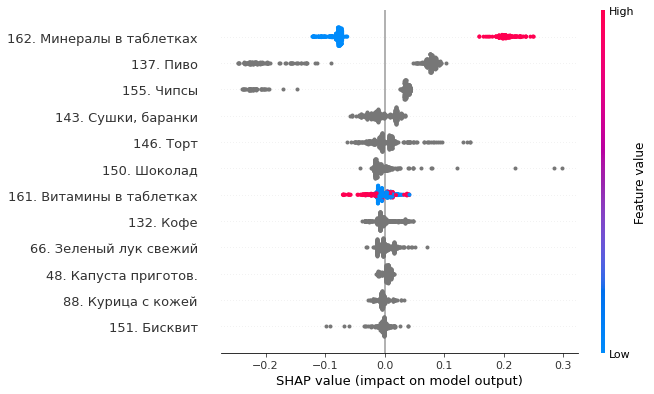

In [169]:
new_feats = [
             '161. Витамины в таблетках',
             '162. Минералы в таблетках',
             '132. Кофе',
 '88. Курица с кожей',
 '137. Пиво',
 '151. Бисквит',
#  '183. Питание в ресторанах',
 '155. Чипсы',
 '146. Торт',
 '150. Шоколад',
#  '148. Печенье',
 '143. Сушки, баранки',
 '48. Капуста приготов.',
 '66. Зеленый лук свежий']
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [170]:
cb_imps2

,cols,imps,imps_not_norm
1,162. Минералы в таблетках,0.116824,0.004936
4,137. Пиво,0.107278,0.013374
6,155. Чипсы,0.058160,0.006306
9,"143. Сушки, баранки",0.017641,-0.004267
7,146. Торт,0.017270,-0.000680
8,150. Шоколад,0.013139,-0.005077
0,161. Витамины в таблетках,0.012947,-0.003776
2,132. Кофе,0.012153,-0.000788
11,66. Зеленый лук свежий,0.008384,0.000621
10,48. Капуста приготов.,0.006128,0.003517


In [171]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

### Питание 2

In [226]:
target = 'Артериальная гипертензия'
list_name = ['Питание2']

Validate AUC (29 features) = 0.600324


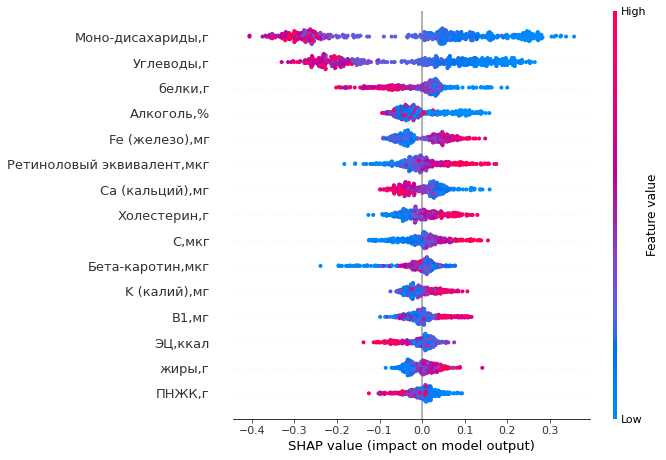

In [179]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

Validate AUC (13 features) = 0.603268


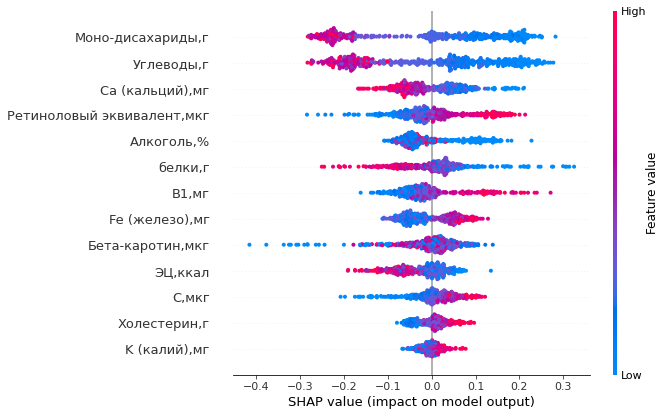

In [190]:
new_feats = list(cb_imps2[cb_imps2.imps>0.026]['cols'])
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [189]:
new_feats

['Моно-дисахариды,г',
 'Углеводы,г',
 'белки,г',
 'Алкоголь,%',
 'Fe (железо),мг',
 'Ретиноловый эквивалент,мкг',
 'Ca (кальций),мг',
 'Холестерин,г',
 'C,мкг',
 'Бета-каротин,мкг',
 'K (калий),мг',
 'B1,мг',
 'ЭЦ,ккал']

In [191]:
cb_imps2

,cols,imps,imps_not_norm
0,"Моно-дисахариды,г",0.149292,-0.011958
1,"Углеводы,г",0.137818,-0.007520
6,"Ca (кальций),мг",0.060451,-0.003874
5,"Ретиноловый эквивалент,мкг",0.060106,0.002806
3,"Алкоголь,%",0.058588,-0.003818
2,"белки,г",0.057033,0.005605
11,"B1,мг",0.051978,-0.007891
4,"Fe (железо),мг",0.049948,-0.002452
9,"Бета-каротин,мкг",0.046525,-0.007159
12,"ЭЦ,ккал",0.044450,-0.025421


In [192]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 2

In [193]:
target = 'ОНМК'

Validate AUC (29 features) = 0.6225


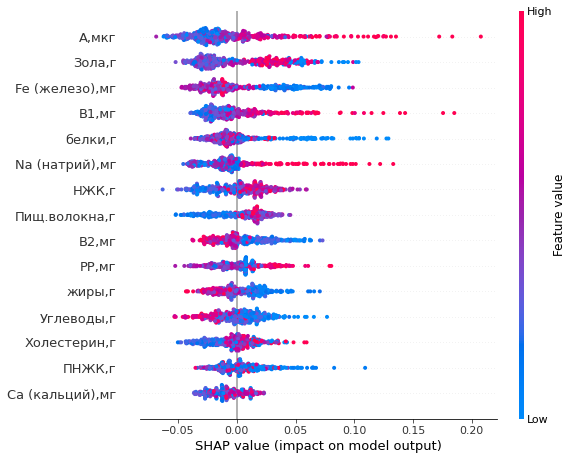

In [194]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [195]:
cb_imps2

,cols,imps,imps_not_norm
18,"A,мкг",0.029752,-0.004281
11,"Зола,г",0.029503,0.004767
17,"Fe (железо),мг",0.027359,0.002746
22,"B1,мг",0.020581,-0.001525
1,"белки,г",0.019231,0.002019
12,"Na (натрий),мг",0.018865,-0.003898
3,"НЖК,г",0.018129,0.000934
9,"Пищ.волокна,г",0.018010,0.003800
23,"B2,мг",0.016109,0.003470
24,"PP,мг",0.015198,0.000547


Validate AUC (13 features) = 0.676304


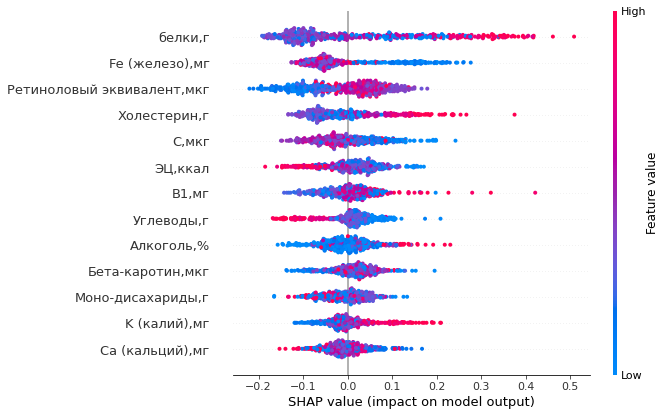

In [196]:
# new_feats = ['Вопрос B3', 'Вопрос B4', 'Время фрукты', 'Время бакалея', 
#              'Вопрос C3', 'Вопрос G1', 'Вопрос C2', 'Вопрос Hc', 'Вопрос D1']
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [197]:
cb_imps2

,cols,imps,imps_not_norm
2,"белки,г",0.134142,0.028175
4,"Fe (железо),мг",0.076915,-0.007649
5,"Ретиноловый эквивалент,мкг",0.073305,-0.012339
7,"Холестерин,г",0.065586,-0.005537
8,"C,мкг",0.053260,0.001773
12,"ЭЦ,ккал",0.047703,0.009969
11,"B1,мг",0.043017,0.004302
1,"Углеводы,г",0.042668,0.006229
3,"Алкоголь,%",0.042179,-0.001027
9,"Бета-каротин,мкг",0.037581,0.012477


In [198]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 3

In [199]:
target = 'Стенокардия, ИБС, инфаркт миокарда'
# list_name = ['Оценка терр']

Validate AUC (29 features) = 0.597609


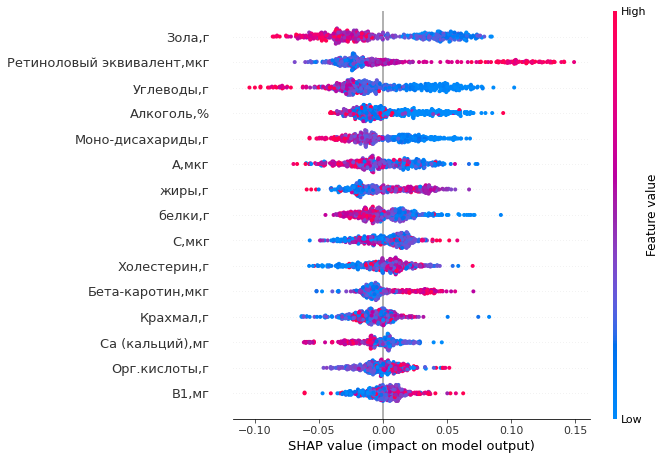

In [200]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [201]:
cb_imps2

,cols,imps,imps_not_norm
11,"Зола,г",0.037505,-0.000288
20,"Ретиноловый эквивалент,мкг",0.035595,0.003757
8,"Углеводы,г",0.031025,0.000426
27,"Алкоголь,%",0.021885,0.005418
6,"Моно-дисахариды,г",0.021479,0.000385
18,"A,мкг",0.020436,-0.000665
2,"жиры,г",0.019806,0.000962
1,"белки,г",0.016051,0.001237
26,"C,мкг",0.015121,0.001668
5,"Холестерин,г",0.014779,0.001020


In [202]:
new_feats

['Моно-дисахариды,г',
 'Углеводы,г',
 'белки,г',
 'Алкоголь,%',
 'Fe (железо),мг',
 'Ретиноловый эквивалент,мкг',
 'Ca (кальций),мг',
 'Холестерин,г',
 'C,мкг',
 'Бета-каротин,мкг',
 'K (калий),мг',
 'B1,мг',
 'ЭЦ,ккал']

Validate AUC (13 features) = 0.613189


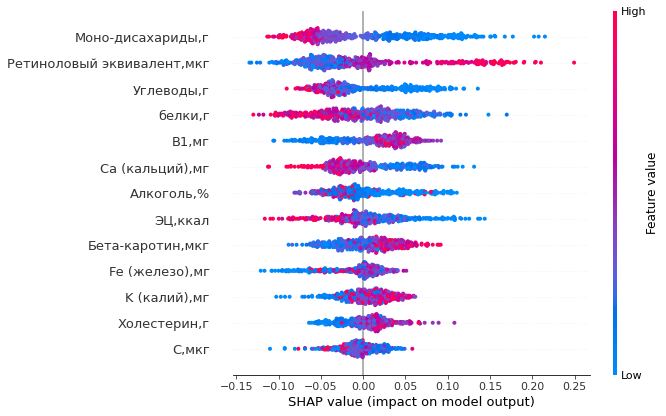

In [203]:
# new_feats = ['Вопрос Hb', 'Время до работы', 'Вопрос B4', 'Вопрос G1', 'Вопрос C3' 
# , 'Вопрос C2', 'Вопрос Hf', 'Время одежда',  'Вопрос He',	'Вопрос D2']
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [204]:
cb_imps2

,cols,imps,imps_not_norm
0,"Моно-дисахариды,г",0.058798,0.003418
5,"Ретиноловый эквивалент,мкг",0.057255,-0.000559
1,"Углеводы,г",0.042723,-0.002786
2,"белки,г",0.041431,-0.000831
11,"B1,мг",0.036555,0.009574
6,"Ca (кальций),мг",0.034294,0.002262
3,"Алкоголь,%",0.031900,0.002666
12,"ЭЦ,ккал",0.031626,0.006789
9,"Бета-каротин,мкг",0.028096,0.004840
4,"Fe (железо),мг",0.022448,-0.008507


In [205]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 4

In [206]:
target = 'Сердечная недостаточность'
# list_name = ['Оценка терр']

Validate AUC (29 features) = 0.629987


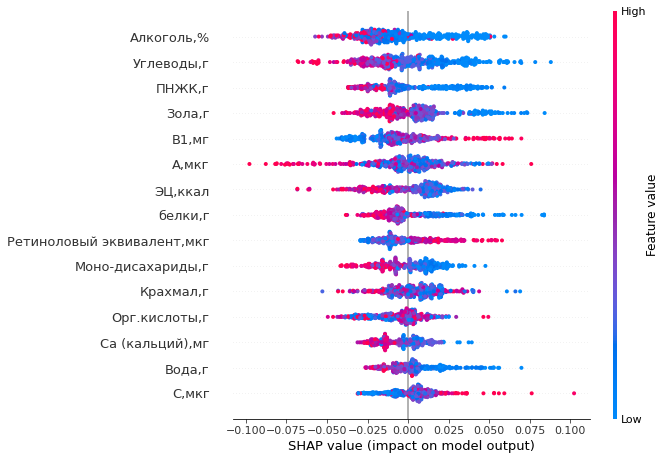

In [207]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [208]:
cb_imps2

,cols,imps,imps_not_norm
27,"Алкоголь,%",0.021599,-0.003858
8,"Углеводы,г",0.020586,0.000723
4,"ПНЖК,г",0.018891,-0.000203
11,"Зола,г",0.017011,0.002895
22,"B1,мг",0.016828,-0.004735
18,"A,мкг",0.016623,-0.002748
28,"ЭЦ,ккал",0.016156,0.001547
1,"белки,г",0.014694,0.000603
20,"Ретиноловый эквивалент,мкг",0.014000,-0.001297
6,"Моно-дисахариды,г",0.013773,0.000132


In [213]:
new_feats = ['Моно-дисахариды,г',
 'Углеводы,г',
 'белки,г',
 'Алкоголь,%',
 'Fe (железо),мг',
 'Ретиноловый эквивалент,мкг',
 'Ca (кальций),мг',
 'Холестерин,г',
 'C,мкг',
 'Бета-каротин,мкг',
 'K (калий),мг',
 'B1,мг',
'ПНЖК,г',
'Зола,г',
'A,мкг',
 'ЭЦ,ккал']



Validate AUC (16 features) = 0.63908


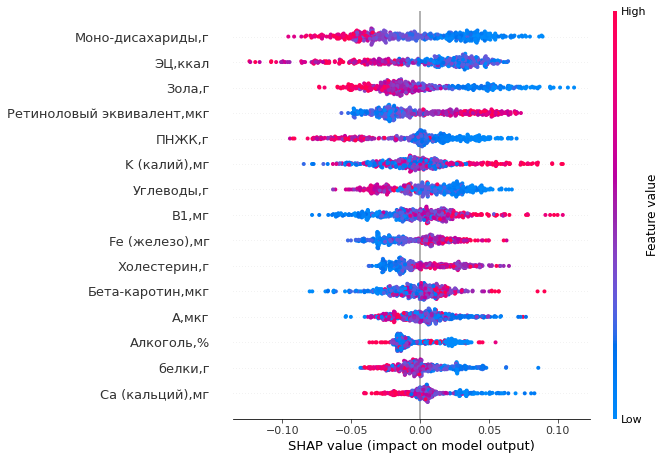

In [214]:
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [215]:
cb_imps2

,cols,imps,imps_not_norm
0,"Моно-дисахариды,г",0.035170,-0.004360
15,"ЭЦ,ккал",0.032792,0.001994
13,"Зола,г",0.028852,-0.000642
5,"Ретиноловый эквивалент,мкг",0.027939,0.001409
12,"ПНЖК,г",0.026167,-0.001800
10,"K (калий),мг",0.022835,0.000590
1,"Углеводы,г",0.022041,0.005025
11,"B1,мг",0.022039,-0.001542
4,"Fe (железо),мг",0.018835,-0.003125
7,"Холестерин,г",0.018194,0.001077


In [216]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 5

In [217]:
target = 'Прочие заболевания сердца'
# list_name = ['Оценка терр']

Validate AUC (29 features) = 0.554003


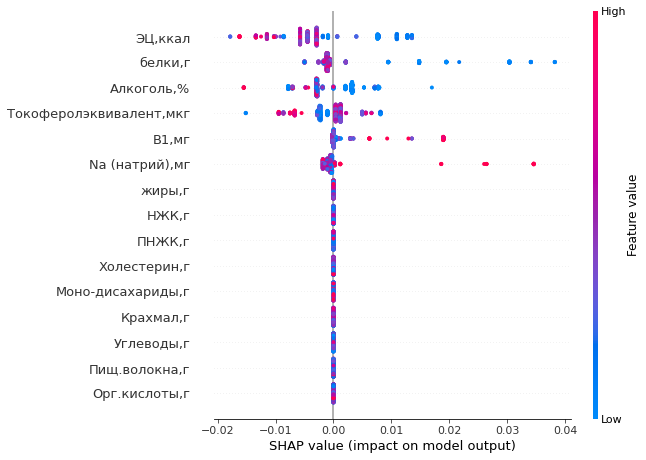

In [218]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [219]:
cb_imps2

,cols,imps,imps_not_norm
28,"ЭЦ,ккал",0.006700,-0.001799
1,"белки,г",0.004401,0.002330
27,"Алкоголь,%",0.003884,-0.000139
21,"Токоферолэквивалент,мкг",0.002786,-0.000813
22,"B1,мг",0.002206,0.002118
12,"Na (натрий),мг",0.001717,0.000022
16,"P,мг",0.000000,0.000000
26,"C,мкг",0.000000,0.000000
25,"Ниациновый эквивалент,мкг",0.000000,0.000000
24,"PP,мг",0.000000,0.000000


Validate AUC (6 features) = 0.562753


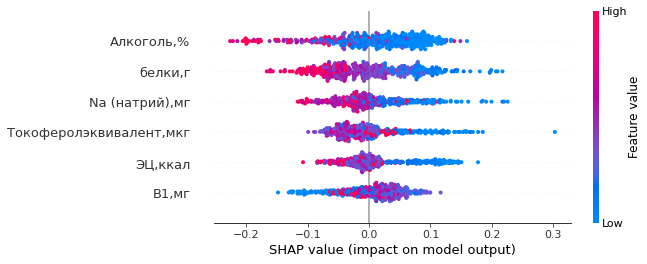

In [220]:
new_feats = [
             'ЭЦ,ккал',
'белки,г',
'Алкоголь,%',	
'Токоферолэквивалент,мкг',
'B1,мг',	
'Na (натрий),мг']
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [221]:
cb_imps2

,cols,imps,imps_not_norm
2,"Алкоголь,%",0.061671,0.007392
1,"белки,г",0.058363,-0.001296
5,"Na (натрий),мг",0.043683,0.003978
3,"Токоферолэквивалент,мкг",0.041595,0.000335
0,"ЭЦ,ккал",0.041249,0.011915
4,"B1,мг",0.038912,0.005182


In [222]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

## Совершен 1

In [262]:
target = 'Артериальная гипертензия'
list_name = ['Совершен1', 'Паспорт']

Validate AUC (91 features) = 0.893448


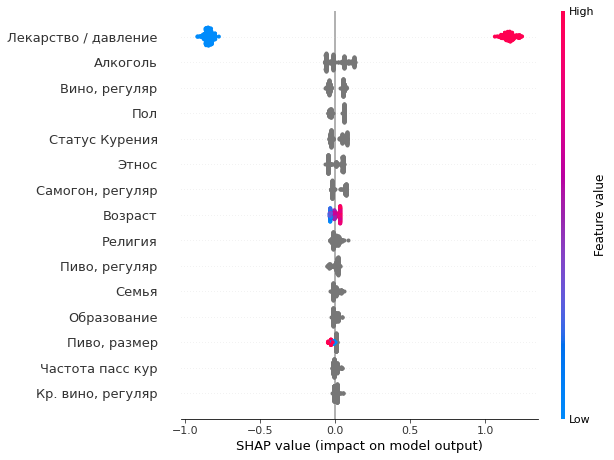

In [265]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

Validate AUC (10 features) = 0.891636


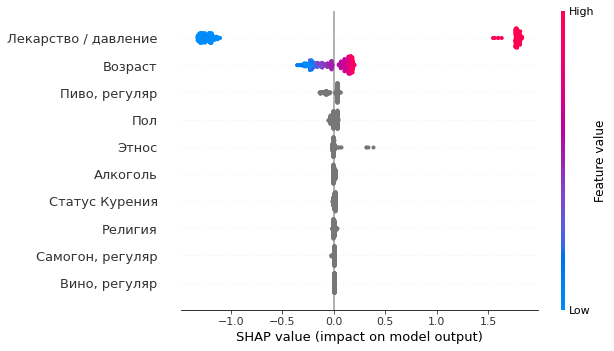

In [273]:
new_feats = list(cb_imps2[cb_imps2.imps>0.015]['cols'])
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [274]:
new_feats

['Лекарство / давление',
 'Алкоголь',
 'Вино, регуляр',
 'Пол',
 'Статус Курения',
 'Этнос',
 'Самогон, регуляр',
 'Возраст',
 'Религия',
 'Пиво, регуляр']

In [275]:
cb_imps2

,cols,imps,imps_not_norm
0,Лекарство / давление,1.471886,0.055350
7,Возраст,0.150673,-0.003791
9,"Пиво, регуляр",0.045464,-0.002340
3,Пол,0.019302,-0.000722
5,Этнос,0.010074,-0.003466
1,Алкоголь,0.004750,-0.000297
4,Статус Курения,0.003651,0.000422
8,Религия,0.003571,0.000666
6,"Самогон, регуляр",0.000579,0.000173
2,"Вино, регуляр",0.000000,0.000000


In [276]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 2

In [277]:
target = 'ОНМК'

Validate AUC (91 features) = 0.840652


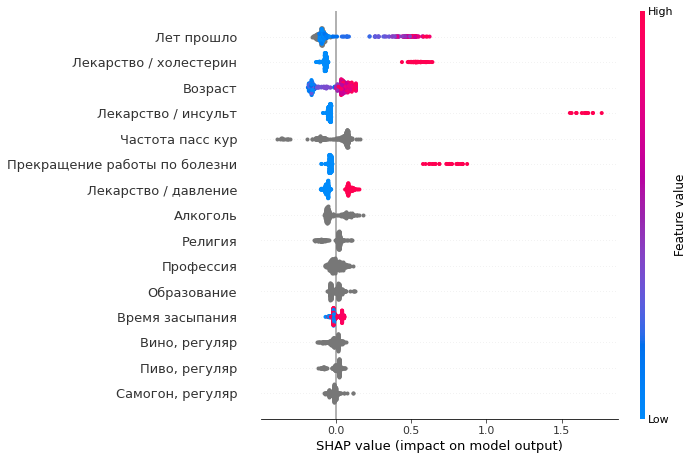

In [278]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [279]:
cb_imps2

,cols,imps,imps_not_norm
38,Лет прошло,0.160891,6.406492e-03
26,Лекарство / холестерин,0.135581,1.295812e-02
90,Возраст,0.089059,-5.377285e-03
27,Лекарство / инсульт,0.084089,5.254006e-03
46,Частота пасс кур,0.080657,1.878406e-02
8,Прекращение работы по болезни,0.076348,6.533838e-03
25,Лекарство / давление,0.073461,4.395095e-03
47,Алкоголь,0.062069,-5.953900e-03
3,Религия,0.032717,1.593762e-03
5,Профессия,0.029114,-2.675318e-03


In [281]:
new_feats

['Лекарство / давление',
 'Алкоголь',
 'Вино, регуляр',
 'Пол',
 'Статус Курения',
 'Этнос',
 'Самогон, регуляр',
 'Возраст',
 'Религия',
 'Пиво, регуляр']

In [283]:
new_feats = ['Лекарство / давление',
 'Алкоголь',
 'Вино, регуляр',
 'Пол',
 'Статус Курения',
 'Этнос',
 'Самогон, регуляр',
 'Возраст', 'Лет прошло',	'Лекарство / холестерин'	,
	'Лекарство / инсульт'	,
	'Прекращение работы по болезни',
 'Религия',
 'Пиво, регуляр']


Validate AUC (14 features) = 0.848043


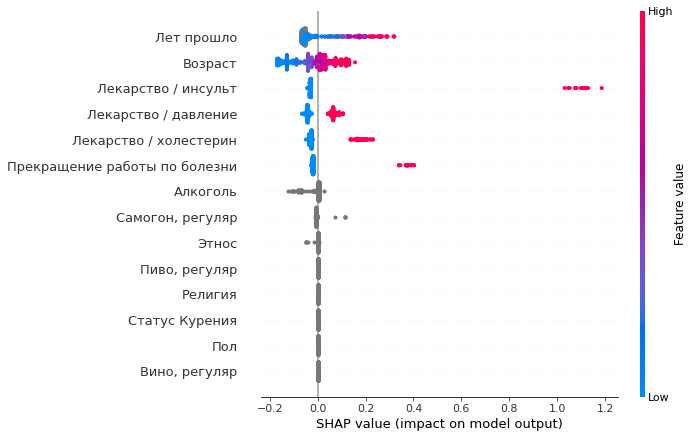

In [284]:
# new_feats = ['Вопрос B3', 'Вопрос B4', 'Время фрукты', 'Время бакалея', 
#              'Вопрос C3', 'Вопрос G1', 'Вопрос C2', 'Вопрос Hc', 'Вопрос D1']
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [285]:
cb_imps2

,cols,imps,imps_not_norm
8,Лет прошло,0.077187,-0.005631
7,Возраст,0.060815,-0.003639
10,Лекарство / инсульт,0.058321,0.001118
0,Лекарство / давление,0.052414,0.004547
9,Лекарство / холестерин,0.049227,-0.000403
11,Прекращение работы по болезни,0.040090,0.002122
1,Алкоголь,0.013252,-0.009338
6,"Самогон, регуляр",0.007022,-0.004840
5,Этнос,0.001477,0.000354
2,"Вино, регуляр",0.000000,0.000000


In [286]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 3

In [287]:
target = 'Стенокардия, ИБС, инфаркт миокарда'
# list_name = ['Оценка терр']

Validate AUC (91 features) = 0.841479


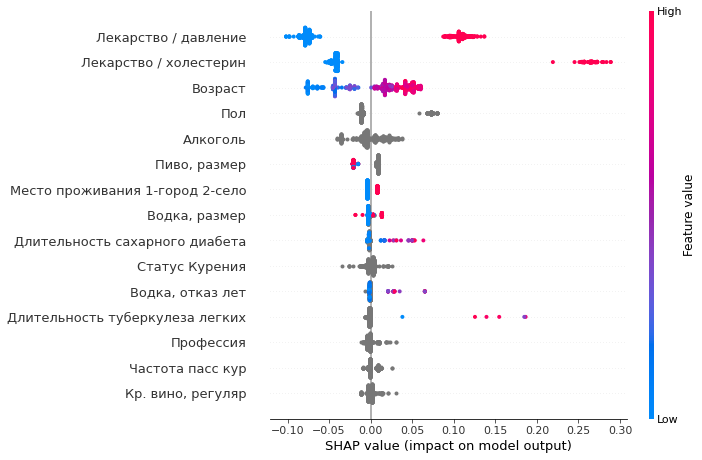

In [288]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [289]:
cb_imps2

,cols,imps,imps_not_norm
25,Лекарство / давление,0.090013,-0.002814
26,Лекарство / холестерин,0.073425,0.000151
90,Возраст,0.038350,0.006510
0,Пол,0.019780,0.000716
47,Алкоголь,0.012734,-0.001944
58,"Пиво, размер",0.011966,-0.000061
89,Место проживания 1-город 2-село,0.005026,-0.000444
49,"Водка, размер",0.004551,-0.000136
10,Длительность сахарного диабета,0.004252,-0.000015
39,Статус Курения,0.004247,-0.000050


In [290]:
new_feats

['Лекарство / давление',
 'Алкоголь',
 'Вино, регуляр',
 'Пол',
 'Статус Курения',
 'Этнос',
 'Самогон, регуляр',
 'Возраст',
 'Лет прошло',
 'Лекарство / холестерин',
 'Лекарство / инсульт',
 'Прекращение работы по болезни',
 'Религия',
 'Пиво, регуляр']

Validate AUC (14 features) = 0.835642


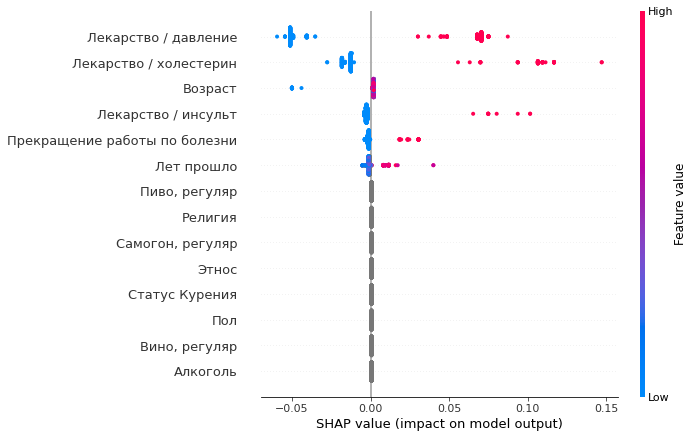

In [291]:
# new_feats = ['Вопрос Hb', 'Время до работы', 'Вопрос B4', 'Вопрос G1', 'Вопрос C3' 
# , 'Вопрос C2', 'Вопрос Hf', 'Время одежда',  'Вопрос He',	'Вопрос D2']
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [292]:
cb_imps2

,cols,imps,imps_not_norm
0,Лекарство / давление,0.057081,-0.002780
9,Лекарство / холестерин,0.027074,0.002095
7,Возраст,0.004519,-0.001091
10,Лекарство / инсульт,0.004365,-0.000967
11,Прекращение работы по болезни,0.002842,-0.000063
8,Лет прошло,0.002488,-0.000112
1,Алкоголь,0.000000,0.000000
2,"Вино, регуляр",0.000000,0.000000
3,Пол,0.000000,0.000000
4,Статус Курения,0.000000,0.000000


In [293]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 4

In [294]:
target = 'Сердечная недостаточность'
# list_name = ['Оценка терр']

Validate AUC (91 features) = 0.773819


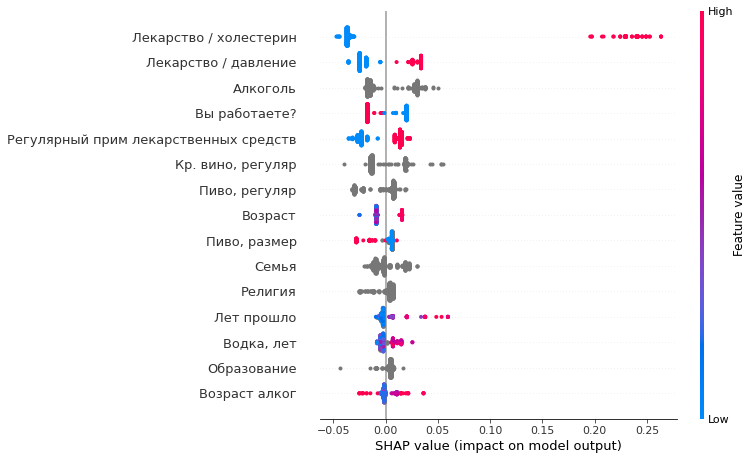

In [295]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [296]:
cb_imps2

,cols,imps,imps_not_norm
26,Лекарство / холестерин,0.064108,0.001511
25,Лекарство / давление,0.026268,-0.001493
47,Алкоголь,0.020502,-0.000232
6,Вы работаете?,0.018222,-0.000503
24,Регулярный прим лекарственных средств,0.017836,-0.001438
68,"Кр. вино, регуляр",0.015858,-0.001797
59,"Пиво, регуляр",0.013340,-0.003895
90,Возраст,0.011386,-0.000229
58,"Пиво, размер",0.008433,-0.000112
1,Семья,0.008291,-0.001116


In [310]:
new_feats = ['Лекарство / давление',
 'Возраст',
 'Лет прошло',
 'Лекарство / холестерин',
 'Лекарство / инсульт',
 'Прекращение работы по болезни',
 'Вы работаете?',]

Validate AUC (7 features) = 0.800715


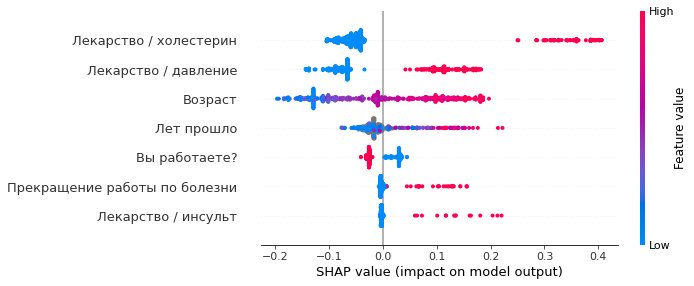

In [311]:
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [312]:
cb_imps2

,cols,imps,imps_not_norm
3,Лекарство / холестерин,0.098523,-0.001381
0,Лекарство / давление,0.096047,-0.001008
1,Возраст,0.093296,-0.006388
2,Лет прошло,0.031910,-0.004037
6,Вы работаете?,0.026964,-0.001949
5,Прекращение работы по болезни,0.009521,0.003891
4,Лекарство / инсульт,0.006623,0.002045


In [313]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')

Таргет 5

In [314]:
target = 'Прочие заболевания сердца'
# list_name = ['Оценка терр']

Validate AUC (91 features) = 0.626035


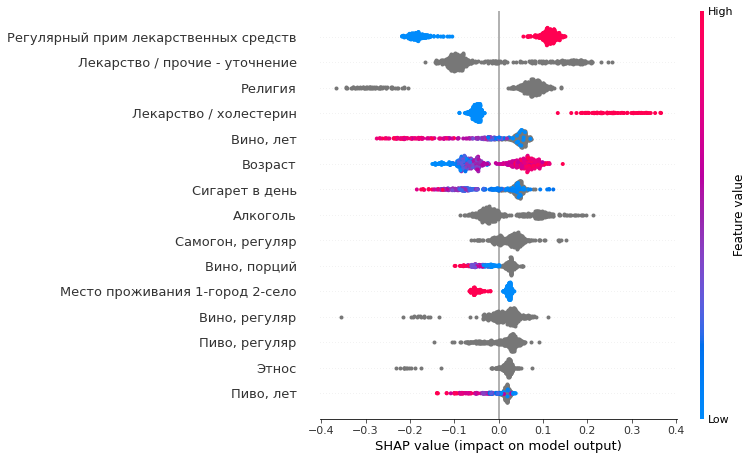

In [315]:
df_all, cols = create_model(df, target, list_name)
train_pool, val_pool, X_val = create_pool(df_all, cols, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [316]:
cb_imps2

,cols,imps,imps_not_norm
24,Регулярный прим лекарственных средств,0.139044,0.006144
32,Лекарство / прочие - уточнение,0.104705,-0.025143
3,Религия,0.103961,0.030949
26,Лекарство / холестерин,0.081340,-0.003728
56,"Вино, лет",0.067446,-0.004855
90,Возраст,0.066933,-0.004453
41,Сигарет в день,0.054802,0.000905
47,Алкоголь,0.051245,0.018456
64,"Самогон, регуляр",0.032063,0.027445
55,"Вино, порций",0.031490,0.000844


Validate AUC (8 features) = 0.638063


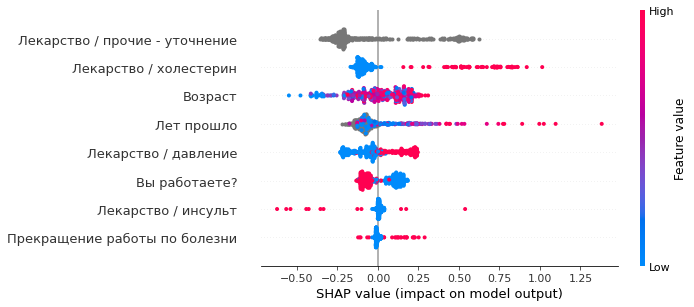

In [318]:
new_feats = ['Лекарство / давление',
 'Возраст',
 'Лет прошло',
 'Лекарство / холестерин',
 'Лекарство / инсульт',
 'Прекращение работы по болезни',
 'Вы работаете?',

'Лекарство / прочие - уточнение'
]
train_pool, val_pool, X_val = create_pool(df_all, new_feats, target)
cb_imps2, cb = hyperparameters(train_pool, val_pool, X_val)

In [319]:
cb_imps2

,cols,imps,imps_not_norm
7,Лекарство / прочие - уточнение,0.256859,-0.069772
3,Лекарство / холестерин,0.172995,0.012619
1,Возраст,0.128381,0.010099
2,Лет прошло,0.123654,-0.015263
0,Лекарство / давление,0.121294,-0.002531
6,Вы работаете?,0.092975,0.011548
4,Лекарство / инсульт,0.018721,0.002429
5,Прекращение работы по болезни,0.017284,-0.000107


In [320]:
joblib.dump(cb, f'models/{target}_{list_name[0]}')
cb_imps2.to_excel(f'feats/{target}_{list_name[0]}.xlsx')